In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
%matplotlib inline
from itertools import combinations
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

In [2]:
def jitter_point(mean,std=0.15):
    return np.random.normal(mean,std)

In [3]:
def calculate_fitness(X,O,Ancestor):
    
    sqdistances = distance.cdist(X,O,metric='sqeuclidean')
    Anc_dist2 = np.broadcast_to(distance.cdist(O,[Ancestor],metric='sqeuclidean').T,(X.shape[0],O.shape[0]))
    est_fitness = np.exp((Anc_dist2 - sqdistances) / 2.0) - 1.0

    return est_fitness

def calculate_fitness_linear(X,O,Ancestor):
    
    sigma = np.eye(X.shape[1],O.shape[0])
    
#     est_fitness = np.dot(X,np.dot(sigma,O.T))
    est_fitness = np.dot(X,O.T)

    return est_fitness

In [4]:
# info_df = p.read_csv('info_df_big.csv')

# n_mutants = 250
# n_conditions = 60
# error_intercept = 0.01
# n_dimensions = 1
# optimum_deviation = 0.1
# anc_max = 0.5
# max_jump = 1.0

n_conditions = 50
# n_conditions = 60
n_mutants = 250
# n_mutants = 500
replicates = 4

true_d_list = [1,2,3,4,5,10,20]

anc_max = 1.0
optimum_deviation = 0.1
max_jump = 0.1
# max_jump = 1.0
fixed_ancestor = True

# error_slope_list = [0.0,0.0,0.0]
error_slope_list = [0.0]
# error_intercept_list = [0.001,0.01,0.1]
error_intercept_list = [0.01]
date_minimum = '2018-05-20'
placer_date = '2018-05-26'
# date_minimum = '2018-03-10'
# placer_date = '2018-05-26'

simulation_management = p.read_csv('simulation_management_fgm_set1.csv')
error_management = p.read_csv('simulation_error_management_fgm_set1.csv')

these_sims = simulation_management[(simulation_management['n_conditions'] == n_conditions) 
                        &  (simulation_management['n_mutants'] == n_mutants) & (simulation_management['anc_max'] == anc_max) &
                        (simulation_management['fixed_ancestor'] == fixed_ancestor) &(simulation_management['max_jump'] == max_jump) 
                        & (simulation_management['optimum_deviation'] == optimum_deviation) & (simulation_management['n_dimensions'].isin(true_d_list))
                        & (simulation_management['datetime'] > date_minimum) ]


In [5]:
def loglikelihood_function(est_fitness,fitness,error,metric='euclidean'):    
        
    log2pi_variance = np.log(np.sqrt(2.0 * np.pi * error))
    inverse_variance = 1.0/error
    log_likelihood = -log2pi_variance - 0.5 * inverse_variance * np.square(fitness - est_fitness)

    return log_likelihood.sum()

def bic(ll,n,k):

    return np.log(n)*k - 2 * ll

def bic1(data,fit,rank):
    
    k = float(rank)
    m = float(data.shape[0])
    n = float(data.shape[1])

    return np.log(np.linalg.norm(data-fit)**2)  + k*(m+n)/(m*n)*np.log(m*n/(m+n))

def bic2(data,fit,rank):
    
    k = float(rank)
    m = float(data.shape[0])
    n = float(data.shape[1])
    C = np.min([np.sqrt(m),np.sqrt(n)])

    return np.log(np.linalg.norm(data-fit)**2)  + k*(m+n)/(m*n)*np.log(C**2)

def bic3(data,fit,rank):
    
    k = float(rank)
    m = float(data.shape[0])
    n = float(data.shape[1])
    C = np.min([np.sqrt(m),np.sqrt(n)])

    return np.log(np.linalg.norm(data-fit)**2)  + k*np.log(C**2)/C**2

def aic(ll,k):

    return 2*k - 2 * ll

def var_explained(data,model):
    
    ss_res = np.sum((data-model)**2)
    ss_tot = np.sum((data-np.mean(data))**2)
    
    return 1 - ss_res/ss_tot, ss_res, ss_tot

In [6]:
def SVD_predictions(data,truth,folds,n_mutants,n_conditions,n_folds,permuted_mutants=False,permuted_conditions=False):
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    all_folds = np.zeros(max_rank)
    true_folds = np.zeros(max_rank)
    for new_m,new_c in folds:
        old_m = sorted([i for i in range(n_mutants) if i not in new_m])
        old_c = sorted([i for i in range(n_conditions) if i not in new_c])
        rank_fit = []
        true_fit = []
        
        if permuted_mutants and permuted_conditions:
            this_data = copy.copy(data)
            this_data[old_m,old_c] = np.random.permutation(this_data[old_m,old_c].ravel()).reshape(len(old_m),len(old_c))
            subset = this_data[np.repeat(old_m,len(old_c)),np.tile(old_c,len(old_m))].ravel()
            
        elif permuted_mutants:
            this_data = copy.copy(data)
            for mut in old_m:
                this_data[mut,old_c] = np.random.permutation(this_data[mut,old_c])
        
        elif permuted_conditions:
            
            this_data = np.swapaxes(copy.copy(data))
            for cond in old_c:
                this_data[cond,old_m] = np.random.permutation(this_data[cond,old_m])
            this_data = np.swapaxes(this_data,0,1)
              
        else:
            this_data = copy.copy(data)
            
            
        
        both_old = this_data[np.repeat(old_m,len(old_c)),np.tile(old_c,len(old_m))].reshape(len(old_m),len(old_c))

        
        U2, s2, V2 = np.linalg.svd(both_old)
        mut_new = this_data[np.repeat(new_m,len(old_c)),np.tile(old_c,len(new_m))].reshape(len(new_m),len(old_c))                    
        cond_new = this_data[np.repeat(old_m,len(new_c)),np.tile(new_c,len(old_m))].reshape(len(old_m),len(new_c))
        both_new = this_data[np.repeat(new_m,len(new_c)),np.tile(new_c,len(new_m))].reshape(len(new_m),len(new_c))
        both_true = truth[np.repeat(new_m,len(new_c)),np.tile(new_c,len(new_m))].reshape(len(new_m),len(new_c))
        
        for rank in range(1,max_rank+1):
     
            new_s = np.asarray(list(s2[:rank]) + list(np.zeros(s2[rank:].shape)))
            S2 = np.zeros((U2.shape[0],V2.shape[0]))
            S2[:min([U2.shape[0],V2.shape[0]]),:min([U2.shape[0],V2.shape[0]])] = np.diag(new_s)

            D_hat = np.dot(U2[:,:rank],np.dot(S2,V2)[:rank,:])
            A_hat = np.dot(mut_new,np.dot(np.linalg.pinv(D_hat),cond_new))

            rank_fit.append(var_explained(both_new,A_hat)[0])
            true_fit.append(var_explained(both_true,A_hat)[0])
        all_folds = all_folds + rank_fit
        true_folds = true_folds + true_fit
        
      
    return all_folds, true_folds

In [7]:
def SVD_fits(data,mse=False):
    U, s, V = np.linalg.svd(data)
    fits = []
    model_vars = []
    bic_1 = []
    bic_2 = []
    bic_3 = []

    for rank in range(1,data.shape[1]+1):
#             print(err,rep,rank)
        this_s = np.asarray(list(s[:rank]) + list(np.zeros(s[rank:].shape)))
        S = np.diag(this_s)
        this_rank = np.dot(U[:,:rank],np.dot(S,V)[:rank,:])
        if mse:
            fits.append(np.sum(np.square(data-this_rank)))
            model_vars.append(np.sum(np.square(data-this_rank)))
        else:
            var_explain, model_var, total_var = var_explained(data,this_rank)
            fits.append(var_explain)
            model_vars.append(model_var)
        bic_1.append(bic1(data,this_rank,rank))
        bic_2.append(bic2(data,this_rank,rank))
        bic_3.append(bic3(data,this_rank,rank))
      
    return fits, model_vars, bic_1, bic_2, bic_3

In [10]:
# these_sims[these_sims['n_dimensions']==10]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
these_sims[these_sims['Sigma2']==sigmas[0]]

Sigma2  anc_max  \
39  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  ...      1.0   
56  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  ...      1.0   
74  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  ...      1.0   
90  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  ...      1.0   

                     batch_name                    datetime fitness_function  \
39  fgm_simulation_set1_default  2018-05-23 21:13:22.710896         Gaussian   
56  fgm_simulation_set1_default  2018-05-23 21:13:24.929811         Gaussian   
74  fgm_simulation_set1_default  2018-05-23 21:13:15.727581         Gaussian   
90  fgm_simulation_set1_default  2018-05-23 21:13:20.389213         Gaussian   

    fixed_ancestor  max_jump  n_conditions  n_dimensions  n_mutants  \
39            True       0.1            50            20        250   
56            True       0.1            50            20        250   
74            True       0.1            50            20        250   
90            True       0.1            50            20        250   

    optimum_deviation  selection             simulation_identifier  \
39                0.1       True  1ebad1cb49cc41868a21fd353a0bf3bc   
56                0.1       True  d9dcbf77ffc84d1f8779968a31d84f42   
74                0.1       True  d22346b30ba54f778aa9ad9586ded679   
90                0.1       True  2ecd8c3aeaf94a69ba6d33c52f6c4915   

    simulation_script                                            weights  
39  FGM_simulation.py  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  ...  
56  FGM_simulation.py  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  ...  
74  FGM_simulation.py  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  ...  
90  FGM_simulation.py  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  ...

In [11]:
sigmas

array(['[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]',
       '[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 1.  1.]',
       '[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]',
       '[ 1.  1.  1.  1.  1.]', '[ 1.  1.  1.  1.]', '[ 1.  1.  1.]',
       '[ 1.  1.]', '[ 1.]'], dtype=object)

In [228]:
""" Fit, BIC, Prediction """


err_list = [1e-4,5e-4,1e-3]
err_list = [i*1e-4 for  i in range(10)]

sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10

sigma = sigmas[1]
color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['Sigma2']==sigma)]
sim_id = sigma_sims['simulation_identifier'].values[0]
d_true = sigma_sims['n_dimensions'].values[0]

f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
f = f[[col for col in f.columns if 'fitness' in col]]
f = f.values
err = (np.var(np.mean(f,axis=0))/np.mean(f))/2.0

d_est = []
for cv in range(n_cvs):
    fit_fig = plt.figure(figsize=(10,5))
#     prd_fig = plt.figure(figsize=(10,5))
    counter = 1
    
    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

    for err in err_list:
        plt.subplot(2,5,counter)
#         prd_ax = prd_fig.subplot(2,5,counter)
        counter += 1
        plt.title(r'$err=${0:.5f}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained, y,x = var_explained(this_set,f)
#         real_fits = SVD_predictions(this_set,folds,n_mutants,n_conditions,n_folds)
#         these_fits = real_fits/n_folds
        
        noprediction,modelfits,bic_1,bic_2,bic_3 = SVD_fits(this_set)
        if err == err_list[0]:
#             print(modelfits)
            
#             print((modelfits - np.asarray(modelfits[1:]+[1.0]))[:d_true])
#             print(1-(modelfits - np.asarray(modelfits[1:]+[1.0]))/np.var(f))
#             print(np.sum(modelfits - np.asarray(modelfits[1:]+[1.0])))
#             print(np.var(f))
#             print(noprediction)
            print(([noprediction[0]]+list((np.asarray(noprediction[1:]+[1.0])-noprediction)))[:d_true])
#             print(np.var(f)*((np.asarray(noprediction[1:]+[1.0])-noprediction))[:d_true])
#         print(1-(modelfits - np.asarray(modelfits[1:]+[1.0]))/np.var(this_set))
#         print(np.var(f))
        print(err,(np.var(this_set)-np.var(f))/np.var(this_set))
        
#         fit_ax.plot(range(1,max_rank+1),these_fits,color='k',label=d_list[item],alpha=1.0)
#         fit_ax.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='k',alpha=1.0)

        plt.plot(range(1,f.shape[1]+1),noprediction,color='k',label=d_true,alpha=1.0)
#         plt.plot(range(1,f.shape[1]),bic_1[:-1],color='b',label=d_true,alpha=1.0)
#         plt.plot(range(1,f.shape[1]),bic_2[:-1],color='g',label=d_true,alpha=1.0)
#         plt.plot(range(1,f.shape[1]),bic_3[:-1],color='r',label=d_true,alpha=1.0)
        plt.axhline(y=true_var_explained,color='b',linestyle=':')
        plt.axvline(x=d_true,color='k',linestyle=':')
        
#         for perm in range(n_permutations):
#             permuted_mutants = copy.copy(this_set)
#             for row in range(this_set.shape[0]):
#                 permuted_mutants[row] = np.random.permutation(this_set[row])
            
#             perm_fits = SVD_predictions(permuted_mutants,folds,n_mutants,n_conditions,n_folds)
#             these_fits = perm_fits/n_folds
            
# #             noprediction = SVD_fits(permuted_mutants)
            
#             plt.plot(range(1,max_rank+1),these_fits,color='gray',label=d_list[item],alpha=0.5,linestyle='--')
#             plt.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='gray',alpha=0.5,linestyle='--')
            
# #             plt.plot(range(1,f.shape[1]+1),noprediction,color='gray',label=d_list[item],alpha=0.5)
    
    fit_fig.tight_layout()
    fit_fig.savefig('SVDAnalysis/d{}_fits_error_range.pdf'.format(d_true),bbox_inches='tight')
    
#     prediction_fig.tight_layout()
#     prediction_fig.savefig('SVDAnalysis/d{}_error_range.pdf'.format(d_true),bbox_inches='tight')




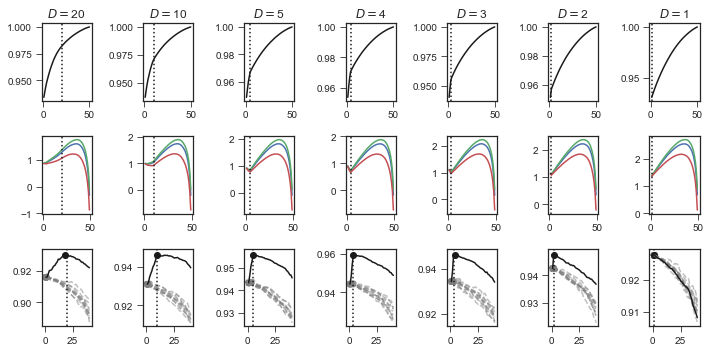

In [18]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims


sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10

fit_fig = plt.figure(figsize=(10,5))

d_est = []
sigmas = sigmas[1:]
for s in range(len(sigmas)):
    sigma = sigmas[s]
    
    color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
    sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['Sigma2']==sigma)]
    sim_id = sigma_sims['simulation_identifier'].values[0]
    d_true = sigma_sims['n_dimensions'].values[0]

    f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
    f = f[[col for col in f.columns if 'fitness' in col]]
    f = f.values
    err = (np.var(np.mean(f,axis=0))/np.mean(f))/2.0
    for cv in range(n_cvs):
        
    #     prd_fig = plt.figure(figsize=(10,5))
        counter = 1

        n_mutants = f.shape[0]
        n_conditions = f.shape[1]
        max_rank = int((n_folds-1)*n_conditions/n_folds)
        new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
        new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

        folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

        plt.subplot(3,7,s+1)
    #         prd_ax = prd_fig.subplot(2,5,counter)
        counter += 1
        plt.title(r'$D=${}'.format(d_true))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained, y,x = var_explained(this_set,f)
    #         real_fits = SVD_predictions(this_set,folds,n_mutants,n_conditions,n_folds)
    #         these_fits = real_fits/n_folds

        noprediction,modelfits,bic_1,bic_2,bic_3 = SVD_fits(this_set)

        plt.plot(range(1,f.shape[1]+1),noprediction,color='k',label=d_true,alpha=1.0)
    #         plt.plot(range(1,f.shape[1]),bic_1[:-1],color='b',label=d_true,alpha=1.0)
    #         plt.plot(range(1,f.shape[1]),bic_2[:-1],color='g',label=d_true,alpha=1.0)
    #         plt.plot(range(1,f.shape[1]),bic_3[:-1],color='r',label=d_true,alpha=1.0)
#         plt.axhline(y=true_var_explained,color='b',linestyle=':')
        plt.axvline(x=d_true,color='k',linestyle=':')
        
        plt.subplot(3,7,7+s+1)
        
        plt.plot(range(1,f.shape[1]),bic_1[:-1],color='b',label=d_true,alpha=1.0)
        plt.plot(range(1,f.shape[1]),bic_2[:-1],color='g',label=d_true,alpha=1.0)
        plt.plot(range(1,f.shape[1]),bic_3[:-1],color='r',label=d_true,alpha=1.0)
#         plt.axhline(y=true_var_explained,color='b',linestyle=':')
        plt.axvline(x=d_true,color='k',linestyle=':')
        
        
        plt.subplot(3,7,14+s+1)
        
        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds)
        real_fits = real_fits/n_folds
#         true_fits = true_fits/n_folds
        
        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)
#             for row in range(this_set.shape[0]):
#                 permuted_mutants[row] = np.random.permutation(this_set[row])
            
            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True)
            perm_fits = perm_fits/n_folds
            
            
            plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')
#         true_fits = true_fits-(true_fits[0]-these_fits[0])
        
        plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)
        plt.axvline(x=d_true,color='k',linestyle=':')

    
fit_fig.tight_layout()
fit_fig.savefig('SVDAnalysis/ALL.pdf'.format(d_true),bbox_inches='tight')




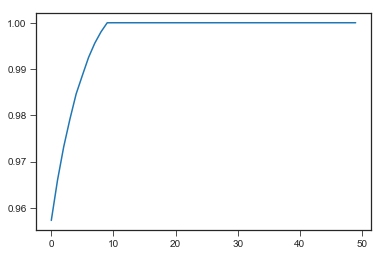

In [8]:
n_mutants = 250
n_conditions = 50
d_true = 10
mutant_center = np.asarray([0.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.5,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[0.5]+[0.5]*(d_true-1),fixed_radius=False)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = Ancestor + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
plt.plot(SVD_fits(f)[0])

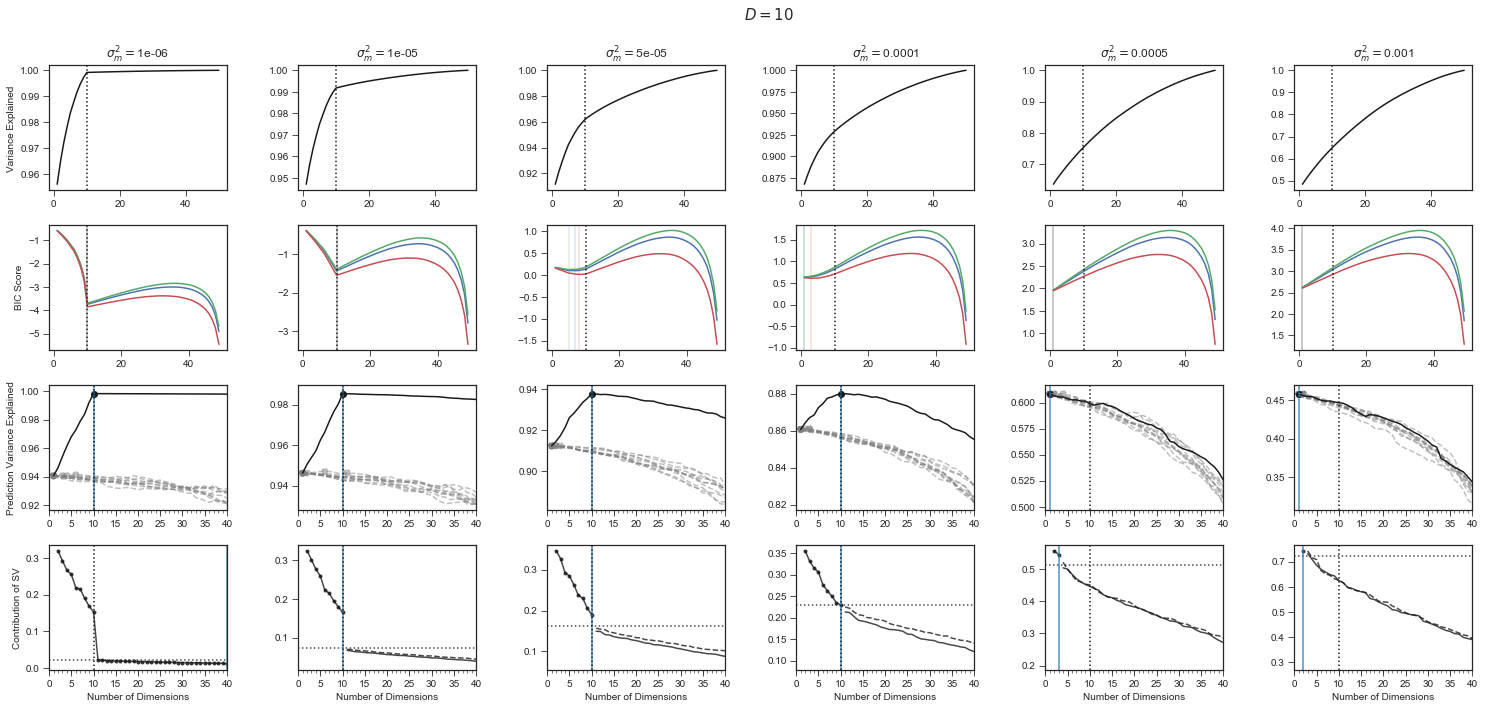

In [17]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims


# sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10
err_list = [1e-10,1e-7,5e-6,7.5e-6,1e-5,2.4e-5,5e-5]
err_list = [1e-10,1e-7,1e-6,1e-5,1e-4,5e-4,1e-3]
err_list = [1e-6,1e-5,5e-5,1e-4,5e-4,1e-3]

max_d = int((n_folds-1)*n_conditions/n_folds)

mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

n_trials = 1

s_list = []
noise_list = []
perm_s_list = []

folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
counter = 1

fit_fig = plt.figure(figsize=(20,10))

d_est = []
# sigmas = sigmas[1:]
for e in range(len(err_list)):
    err = err_list[e]
    epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    this_set = f + epsilons
    U, s, V = np.linalg.svd(this_set)
    s_list.append(s)
    U, noise_s, V = np.linalg.svd(epsilons)
    noise_list.append(noise_s)
        
    U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
    perm_s_list.append(perm_s)
    
    color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}

    for cv in range(n_cvs):
        
    #     prd_fig = plt.figure(figsize=(10,5))

        n_mutants = f.shape[0]
        n_conditions = f.shape[1]
        max_rank = int((n_folds-1)*n_conditions/n_folds)
        new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
        new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

        folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
        
        ## Raw SVD elbow
        plt.subplot(4,len(err_list),e+1)
        if e == 0:
            plt.ylabel('Variance Explained ')

        plt.title(r'$\sigma_m^2=${}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained, y,x = var_explained(this_set,f)

        noprediction,modelfits,bic_1,bic_2,bic_3 = SVD_fits(this_set)

        plt.plot(range(1,f.shape[1]+1),noprediction,color='k',label=d_true,alpha=1.0)
        plt.axvline(x=d_true,color='k',linestyle=':')
        
        ## BIC
        plt.subplot(4,len(err_list),len(err_list)+e+1)
        if e == 0:
            plt.ylabel('BIC Score')
        
        plt.plot(range(1,f.shape[1]),bic_1[:-1],color='b',label=d_true,alpha=1.0)
        plt.axvline(x=range(1,f.shape[1])[np.where(bic_1[:30]==np.min(bic_1[:30]))[0][0]],color='b',alpha=0.2)
        plt.plot(range(1,f.shape[1]),bic_2[:-1],color='g',label=d_true,alpha=1.0)
        plt.axvline(x=range(1,f.shape[1])[np.where(bic_2[:30]==np.min(bic_2[:30]))[0][0]],color='g',alpha=0.2)
        plt.plot(range(1,f.shape[1]),bic_3[:-1],color='r',label=d_true,alpha=1.0)
        plt.axvline(x=range(1,f.shape[1])[np.where(bic_3[:30]==np.min(bic_3[:30]))[0][0]],color='r',alpha=0.2)
#         plt.axhline(y=true_var_explained,color='b',linestyle=':')
        plt.axvline(x=d_true,color='k',linestyle=':')
        
        ## Prediction 
        plt.subplot(4,len(err_list),2*len(err_list)+e+1)
        if e == 0:
            plt.ylabel('Prediction Variance Explained')
        
        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds)
        real_fits = real_fits/n_folds
        
        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)
            
            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True)
            perm_fits = perm_fits/n_folds
            
            plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')
        
        plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)
        plt.axvline(x=range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],linestyle='-',alpha=0.8)
        plt.axvline(x=d_true,color='k',linestyle=':')
        
        plt.xlim(0,max_d)
        plt.xticks(np.arange(0,max_d+5,5),np.arange(0,max_d+5,5))
        plt.gca().set_xticks(range(max_d),True)

    
for e in range(len(err_list)):
    ax = plt.subplot(4,len(err_list),3*len(err_list)+e+1)
    
    if e == 0:
        plt.ylabel('Contribution of SV')
    
    err = err_list[e]
    
    s = s_list[e]
    noise_s = noise_list[e]
    perm_s = perm_s_list[e]
#     max_d = len(s)
    

    if err != err_list[0]:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = max_d
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],color='k',marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
#     plt.plot(np.arange(1,max_d+1),perm_s,linestyle=':',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    plt.axvline(x=max_detectable,linestyle='-',alpha=0.8)
    plt.axvline(x=d_true,color='k',linestyle=':')


    plt.xlim(0,max_d)
    plt.xticks(np.arange(0,max_d+5,5),np.arange(0,max_d+5,5))
    plt.gca().set_xticks(range(max_d),True)
    plt.xlabel('Number of Dimensions')
    
plt.suptitle(r'$D={}$'.format(d_true),fontsize=15)

plt.tight_layout()
plt.subplots_adjust(left=0.0, wspace=0.4, top=0.9)
# fit_fig.savefig('SVDAnalysis/method_comparison_rough_{}.pdf'.format(d_true),bbox_inches='tight')





In [39]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims


# sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10
err_list = [1e-10,1e-7,5e-6,7.5e-6,1e-5,2.4e-5,5e-5]
err_list = [1e-10,1e-7,1e-6,1e-5,1e-4,5e-4,1e-3]
err_list = [1e-6,1e-5,5e-5,1e-4,5e-4,1e-3]

max_d = int((n_folds-1)*n_conditions/n_folds)

mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

n_trials = 1

s_list = []
noise_list = []
perm_s_list = []

folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]


rawfit_list =  []
bic1_list = []
bic2_list = []
bic3_list = []
cv_list = []
md_list = []
sv_list = []


d_est = []
err_list = np.logspace(-8,0,40)

for err in err_list:

    epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    this_set = f + epsilons
    U, s, V = np.linalg.svd(this_set)
    s_list.append(s)
    U, noise_s, V = np.linalg.svd(epsilons)
    noise_list.append(noise_s)
        
    U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
    perm_s_list.append(perm_s)
    
    color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}

    for cv in range(n_cvs):
        

        n_mutants = f.shape[0]
        n_conditions = f.shape[1]
        max_rank = int((n_folds-1)*n_conditions/n_folds)
        new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
        new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

        folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
        
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained, y,x = var_explained(this_set,f)

        noprediction,modelfits,bic_1,bic_2,bic_3 = SVD_fits(this_set)

        rawfit_list.append(noprediction)
    
        bic1_list.append(range(1,f.shape[1])[np.where(bic_1[:30]==np.min(bic_1[:30]))[0][0]])
        bic2_list.append(range(1,f.shape[1])[np.where(bic_2[:30]==np.min(bic_2[:30]))[0][0]])
        bic3_list.append(range(1,f.shape[1])[np.where(bic_3[:30]==np.min(bic_3[:30]))[0][0]])

        
        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds)
        real_fits = real_fits/n_folds
        
        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)
            
            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True)
            perm_fits = perm_fits/n_folds
            

        cv_list.append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
    
for e in range(len(err_list)):
    err = err_list[e]
    
    
    s = s_list[e]
    noise_s = noise_list[e]
    perm_s = perm_s_list[e]
    
    max_detectable = np.where(s < noise_s[0])[0][0]

    md_list.append(max_detectable)
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    sv_list.append(range(1,max_rank+1)[np.where(s < sv)[0][0]])





Text(0.5,0,'Measurement Error')

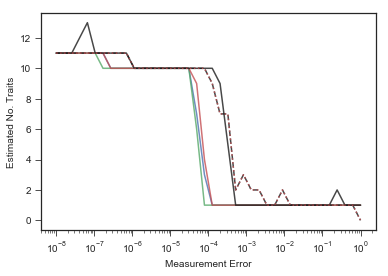

In [42]:
plt.plot(err_list,bic1_list,color='b',alpha=0.8)
plt.plot(err_list,bic2_list,color='g',alpha=0.8)
plt.plot(err_list,bic3_list,color='r',alpha=0.8)
plt.plot(err_list,cv_list,'k',alpha=0.8)
plt.plot(err_list,md_list,'k--',alpha=0.8)
plt.plot(err_list,md_list,'r:',alpha=0.8)
plt.xscale('log')
plt.ylabel('Estimated No. Traits')
plt.xlabel('Measurement Error')

In [43]:
mutant_points

[[-0.017366114085789836,
  0.007823379903495789,
  -0.010732261349623039,
  0.02074382803387775,
  0.00963342552470156,
  -0.024941315741125077,
  -0.009284295046858761,
  -0.02164778958286648,
  0.005837309922655599,
  -0.0055749355032340756],
 [-0.0026719309761813414,
  0.017972730355275243,
  -0.005420845349024855,
  -0.021242585140173464,
  -0.0063634687629293574,
  -0.0036113395938966947,
  -0.005382563595289975,
  -0.025653128631648404,
  -0.003828418341536892,
  0.025186321663777288],
 [0.0044624181284444635,
  -0.014100606208930323,
  -0.006337106144242885,
  0.028866855383461596,
  0.015881543138073998,
  -0.013939909994260147,
  0.002357169681929515,
  0.006576411897024217,
  -0.010356987555580855,
  0.01988521983316214],
 [-0.012998766930026762,
  -0.004732470251436748,
  0.007175054029370177,
  -0.009775654948052034,
  -0.008328226069859073,
  -0.02829444549273643,
  0.004672334324923641,
  -0.005674427763627705,
  -0.01206181346221473,
  0.026831153270105757],
 [0.02956118

[0.9677125167328675, 0.004160361116991473, 0.0036267517298570473, 0.003273237195622336, 0.002862278799505402, 0.0024114268827887253, 0.0020538648827981287, 0.0018872256854458591, 0.0017774840895891098, 0.0017086918215931668, 0.0014864937276498624, 0.0012962973394610167, 0.001231638153911807, 0.0010976648855546278, 0.0007645662188969782, 0.0006842274656877478, 0.0006555983753407935, 0.0004843442150184174, 0.00041961550777847023, 0.0002584386005216599]
0.0 1.7028083944666828e-16
0.0001 0.03710654341795792
0.0002 0.0787522628633439
0.00030000000000000003 0.10805966934838199
0.0004 0.13341865217574272
0.0005 0.15988713491948678
0.0006000000000000001 0.19822372913389072
0.0007 0.22374403898872694
0.0008 0.24421915217711135
0.0009000000000000001 0.26439891244094804


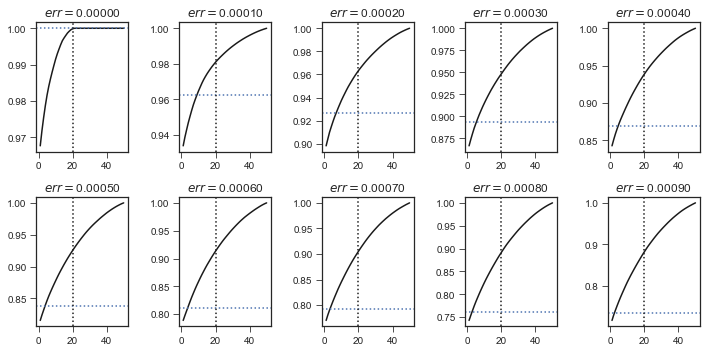

In [125]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims

# np.random.seed(9)

err_list = [1e-4,5e-4,1e-3]
err_list = [i*1e-4 for  i in range(10)]

sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10

sigma = sigmas[1]
color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['Sigma2']==sigma)]
sim_id = sigma_sims['simulation_identifier'].values[0]
d_true = sigma_sims['n_dimensions'].values[0]

f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
f = f[[col for col in f.columns if 'fitness' in col]]
f = f.values
err = (np.var(np.mean(f,axis=0))/np.mean(f))/2.0

d_est = []
for cv in range(n_cvs):
    fit_fig = plt.figure(figsize=(10,5))
#     prd_fig = plt.figure(figsize=(10,5))
    counter = 1
    
    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

    for err in err_list:
        plt.subplot(2,5,counter)
#         prd_ax = prd_fig.subplot(2,5,counter)
        counter += 1
        plt.title(r'$err=${0:.5f}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained, y,x = var_explained(this_set,f)
#         real_fits = SVD_predictions(this_set,folds,n_mutants,n_conditions,n_folds)
#         these_fits = real_fits/n_folds
        
        noprediction,modelfits,bic_1,bic_2,bic_3 = SVD_fits(this_set)
        if err == err_list[0]:
#             print(modelfits)
            
#             print((modelfits - np.asarray(modelfits[1:]+[1.0]))[:d_true])
#             print(1-(modelfits - np.asarray(modelfits[1:]+[1.0]))/np.var(f))
#             print(np.sum(modelfits - np.asarray(modelfits[1:]+[1.0])))
#             print(np.var(f))
#             print(noprediction)
            print(([noprediction[0]]+list((np.asarray(noprediction[1:]+[1.0])-noprediction)))[:d_true])
#             print(np.var(f)*((np.asarray(noprediction[1:]+[1.0])-noprediction))[:d_true])
#         print(1-(modelfits - np.asarray(modelfits[1:]+[1.0]))/np.var(this_set))
#         print(np.var(f))
        print(err,(np.var(this_set)-np.var(f))/np.var(this_set))
        
#         fit_ax.plot(range(1,max_rank+1),these_fits,color='k',label=d_list[item],alpha=1.0)
#         fit_ax.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='k',alpha=1.0)

        plt.plot(range(1,f.shape[1]+1),noprediction,color='k',label=d_true,alpha=1.0)
#         plt.plot(range(1,f.shape[1]),bic_1[:-1],color='b',label=d_true,alpha=1.0)
#         plt.plot(range(1,f.shape[1]),bic_2[:-1],color='g',label=d_true,alpha=1.0)
#         plt.plot(range(1,f.shape[1]),bic_3[:-1],color='r',label=d_true,alpha=1.0)
        plt.axhline(y=true_var_explained,color='b',linestyle=':')
        plt.axvline(x=d_true,color='k',linestyle=':')
        
#         for perm in range(n_permutations):
#             permuted_mutants = copy.copy(this_set)
#             for row in range(this_set.shape[0]):
#                 permuted_mutants[row] = np.random.permutation(this_set[row])
            
#             perm_fits = SVD_predictions(permuted_mutants,folds,n_mutants,n_conditions,n_folds)
#             these_fits = perm_fits/n_folds
            
# #             noprediction = SVD_fits(permuted_mutants)
            
#             plt.plot(range(1,max_rank+1),these_fits,color='gray',label=d_list[item],alpha=0.5,linestyle='--')
#             plt.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='gray',alpha=0.5,linestyle='--')
            
# #             plt.plot(range(1,f.shape[1]+1),noprediction,color='gray',label=d_list[item],alpha=0.5)
    
    fit_fig.tight_layout()
    fit_fig.savefig('SVDAnalysis/d{}_fits_error_range.pdf'.format(d_true),bbox_inches='tight')
    
#     prediction_fig.tight_layout()
#     prediction_fig.savefig('SVDAnalysis/d{}_error_range.pdf'.format(d_true),bbox_inches='tight')



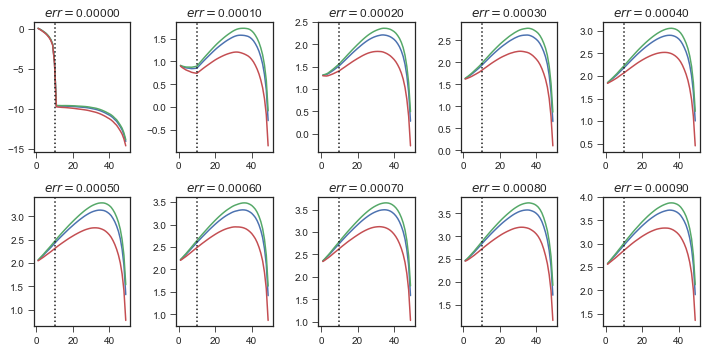

In [60]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims

# np.random.seed(9)

err_list = [1e-4,5e-4,1e-3]
err_list = [i*1e-4 for  i in range(10)]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10

sigma = sigmas[2]
color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['Sigma2']==sigma)]
sim_id = sigma_sims['simulation_identifier'].values[0]
d_true = sigma_sims['n_dimensions'].values[0]

f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
f = f[[col for col in f.columns if 'fitness' in col]]
f = f.values

d_est = []
for cv in range(n_cvs):
    fit_fig = plt.figure(figsize=(10,5))
#     prd_fig = plt.figure(figsize=(10,5))
    counter = 1
    
    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

    for err in err_list:
        plt.subplot(2,5,counter)
#         prd_ax = prd_fig.subplot(2,5,counter)
        counter += 1
        plt.title(r'$err=${0:.5f}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        
#         real_fits = SVD_predictions(this_set,folds,n_mutants,n_conditions,n_folds)
#         these_fits = real_fits/n_folds
        
        noprediction,bic_1,bic_2,bic_3 = SVD_fits(this_set)
        
#         fit_ax.plot(range(1,max_rank+1),these_fits,color='k',label=d_list[item],alpha=1.0)
#         fit_ax.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='k',alpha=1.0)

#         plt.plot(range(1,f.shape[1]+1),noprediction,color='k',label=d_true,alpha=1.0)
        plt.plot(range(1,f.shape[1]),bic_1[:-1],color='b',label=d_true,alpha=1.0)
        plt.plot(range(1,f.shape[1]),bic_2[:-1],color='g',label=d_true,alpha=1.0)
        plt.plot(range(1,f.shape[1]),bic_3[:-1],color='r',label=d_true,alpha=1.0)
        plt.axvline(x=d_true,color='k',linestyle=':')
        
#         for perm in range(n_permutations):
#             permuted_mutants = copy.copy(this_set)
#             for row in range(this_set.shape[0]):
#                 permuted_mutants[row] = np.random.permutation(this_set[row])
            
#             perm_fits = SVD_predictions(permuted_mutants,folds,n_mutants,n_conditions,n_folds)
#             these_fits = perm_fits/n_folds
            
# #             noprediction = SVD_fits(permuted_mutants)
            
#             plt.plot(range(1,max_rank+1),these_fits,color='gray',label=d_list[item],alpha=0.5,linestyle='--')
#             plt.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='gray',alpha=0.5,linestyle='--')
            
# #             plt.plot(range(1,f.shape[1]+1),noprediction,color='gray',label=d_list[item],alpha=0.5)
    
    fit_fig.tight_layout()
    fit_fig.savefig('SVDAnalysis/d{}_BICs_error_range.pdf'.format(d_true),bbox_inches='tight')
    
#     prediction_fig.tight_layout()
#     prediction_fig.savefig('SVDAnalysis/d{}_error_range.pdf'.format(d_true),bbox_inches='tight')


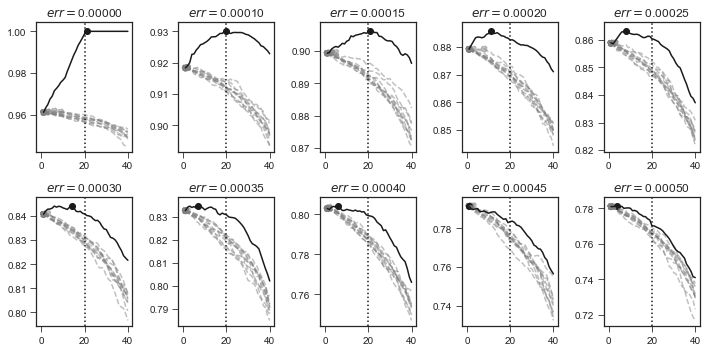

In [84]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims

# np.random.seed(9)

err_list = [1e-4,5e-4,1e-3]
err_list = [0]+[i*0.5e-4 for  i in range(2,11)]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10

sigma = sigmas[1]
color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['Sigma2']==sigma)]
sim_id = sigma_sims['simulation_identifier'].values[0]
d_true = sigma_sims['n_dimensions'].values[0]

f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
f = f[[col for col in f.columns if 'fitness' in col]]
f = f.values

d_est = []
d_list = []
for cv in range(n_cvs):
    fig = plt.figure(figsize=(10,5))
    counter = 1
    
    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

    for err in err_list:
        ax = plt.subplot(2,5,counter)
        counter += 1
        plt.title(r'$err=${0:.5f}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained = var_explained(this_set,f)
        
        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds)
        real_fits = real_fits/n_folds
#         true_fits = true_fits/n_folds
        
        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)
#             for row in range(this_set.shape[0]):
#                 permuted_mutants[row] = np.random.permutation(this_set[row])
            
            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True)
            perm_fits = perm_fits/n_folds
            
            
            plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')
#         true_fits = true_fits-(true_fits[0]-these_fits[0])
        
        plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)
        
#         plt.plot(range(1,max_rank+1),true_fits,color='r',label=d_true,alpha=1.0)
#         plt.scatter(range(1,max_rank+1)[np.where(true_fits==np.max(true_fits))[0][0]],np.max(true_fits),color='r',alpha=1.0)

#         plt.xlabel('D estimated')
#         plt.ylabel('Variance Explained in Test Set')
        plt.axvline(x=d_true,color='k',linestyle=':')
#         plt.axhline(y=true_var_explained,color='b',linestyle=':')

        
#         true_var_explained.append(real_fits/n_folds)
        

#     ax.
    fig.tight_layout()
    plt.savefig('SVDAnalysis/d{}_permTrain_error_range.pdf'.format(d_true),bbox_inches='tight')



In [83]:
np.var(f)

0.002546856536551371

TypeError: SVD_predictions() missing 1 required positional argument: 'n_folds'

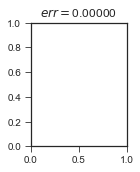

In [63]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims

# np.random.seed(9)

err_list = [1e-4,5e-4,1e-3]
err_list = [i*1e-4 for  i in range(10)]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10

sigma = sigmas[1]
color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['Sigma2']==sigma)]
sim_id = sigma_sims['simulation_identifier'].values[0]
d_true = sigma_sims['n_dimensions'].values[0]

f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
f = f[[col for col in f.columns if 'fitness' in col]]
f = f.values

d_est = []
for cv in range(n_cvs):
    fig = plt.figure(figsize=(10,5))
    counter = 1
    
    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

    for err in err_list:
        ax = plt.subplot(2,5,counter)
        counter += 1
        plt.title(r'$err=${0:.5f}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        
        real_fits, true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds)
        these_fits = real_fits/n_folds
        
        plt.plot(range(1,max_rank+1),these_fits,color='k',label=d_list[item],alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='k',alpha=1.0)
#         plt.xlabel('D estimated')
#         plt.ylabel('Variance Explained in Test Set')

        
#         true_var_explained.append(real_fits/n_folds)
        
        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)
            for row in range(this_set.shape[0]):
                permuted_mutants[row] = np.random.permutation(this_set[row])
            
            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds)
            these_fits = perm_fits/n_folds
            
            plt.plot(range(1,max_rank+1),these_fits,color='gray',label=d_list[item],alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='gray',alpha=0.5,linestyle='--')
#     ax.
    fig.tight_layout()
    plt.savefig('SVDAnalysis/d{}_error_range.pdf'.format(d_true),bbox_inches='tight')



(0, 1.1)

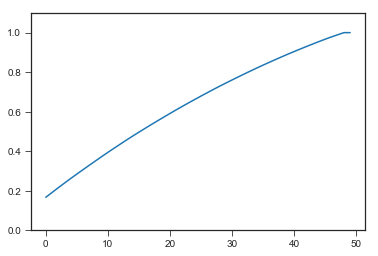

In [13]:


# reps = 5
# sim_id = 'd8e3f2a1e8f04d2e918c4c6052cf9337'
# d_true = 3
err_list = [0.001,0.01,0.1]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)

for e in err_list:
#     plt.figure()
    sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['']==sigma)]
    for err in err_list: 
        plt.figure()
        for sim_id in sigma_sims['simulation_identifier'].values:
            d_true = sigma_sims['n_dimensions'].values[0]
            f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
            f = f[[col for col in f.columns if 'fitness' in col]]
            f = f.values
            

            this_set = f
            this_set = np.asarray([np.random.normal(this_set.flatten()[i],err) for i in range(len(this_set.flatten()))]).reshape(this_set.shape[0],this_set.shape[1])
            U, s, V = np.linalg.svd(this_set)
            rank_fit = []
            for rank in range(1,this_set.shape[1]):
    #             print(err,rep,rank)
                this_s = np.asarray(list(s[:rank]) + list(np.zeros(s[rank:].shape)))
                S = np.diag(this_s)
                this_rank = np.dot(U[:,:rank],np.dot(S,V)[:rank,:])

        #             rank_fit.append(pearsonr(this_set.flatten(),this_rank.flatten())[0])
                ll = loglikelihood_function(this_rank.flatten(),this_set.flatten(),np.asarray([err]*len(this_set.flatten())))
                rank_fit.append(ll)
    #             rank_fit.append(aic(ll,rank*(this_set.shape[1]+this_set.shape[0])))
    #             rank_fit.append(bic(ll,this_set.shape[1]*this_set.shape[0],rank*(this_set.shape[1]+this_set.shape[0])))


            plt.title(str(sigma)+'  '+str(d_true)+'  '+str(err))
#             plt.plot(range(1,this_set.shape[1]),(rank_fit-rank_fit[-1])/rank_fit[-1])
#             plt.axvline(x=d_true,color='k',linestyle='--',alpha=0.4)
#             plt.figure()
            plt.plot(range(1,this_set.shape[1]+1),np.cumsum(np.diag(S))/np.sum(np.diag(S)))
            plt.axvline(x=d_true,color='k',linestyle='--',alpha=0.4)
#         plt.legend()



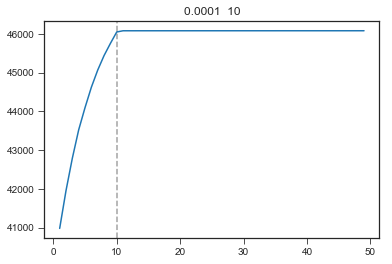

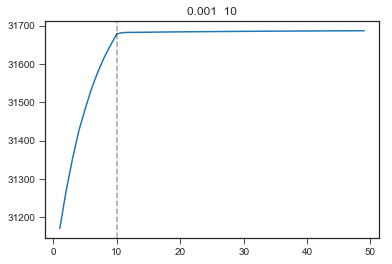

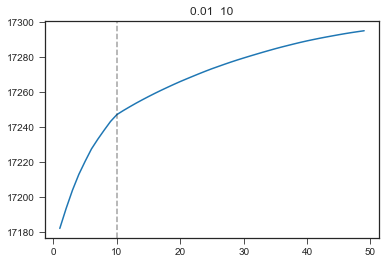

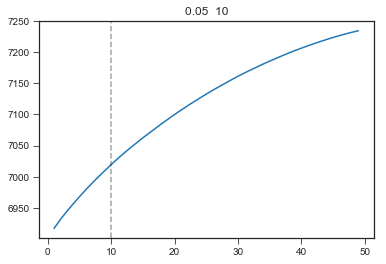

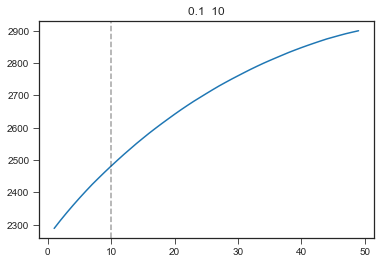

In [167]:
# sim_id = 'd8e3f2a1e8f04d2e918c4c6052cf9337'
# d_true = 5
reps = 1
sim_id = '5b0e79b2fe814b87bacec50765cae6f8'
d_true = 10

f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
f = f[[col for col in f.columns if 'fitness' in col]]
f = f.values
for err in [0.0001,0.001,0.01,0.05,0.1]:
# for err in [0.001,0.1]:
#     print(err)
    plt.figure()
    for rep in range(reps):
#         print(rep)
        this_set = f
        this_set = np.asarray([np.random.normal(this_set.flatten()[i],err) for i in range(len(this_set.flatten()))]).reshape(this_set.shape[0],this_set.shape[1])
        U, s, V = np.linalg.svd(this_set)
        rank_fit = []
        for rank in range(1,this_set.shape[1]):
#             print(err,rep,rank)
            this_s = np.asarray(list(s[:rank]) + list(np.zeros(s[rank:].shape)))
            S = np.diag(this_s)
            this_rank = np.dot(U[:,:rank],np.dot(S,V)[:rank,:])

    #             rank_fit.append(pearsonr(this_set.flatten(),this_rank.flatten())[0])
            ll = loglikelihood_function(this_rank.flatten(),this_set.flatten(),np.asarray([err]*len(this_set.flatten())))
            rank_fit.append(ll)
#             rank_fit.append(aic(ll,rank*(this_set.shape[1]+this_set.shape[0])))
#             rank_fit.append(bic(ll,this_set.shape[1]*this_set.shape[0],rank*(this_set.shape[1]+this_set.shape[0])))


        plt.title(str(err)+'  '+str(d_true))
        plt.plot(range(1,this_set.shape[1]),rank_fit)
        plt.axvline(x=d_true,color='k',linestyle='--',alpha=0.4)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


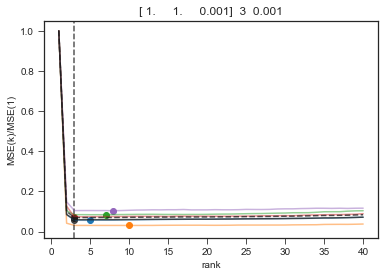

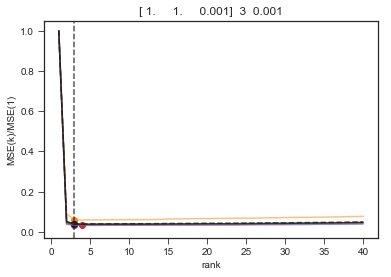

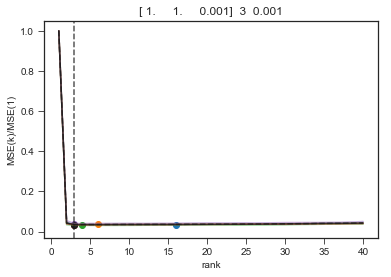

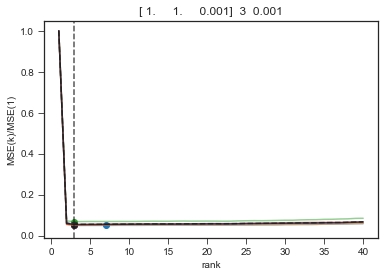

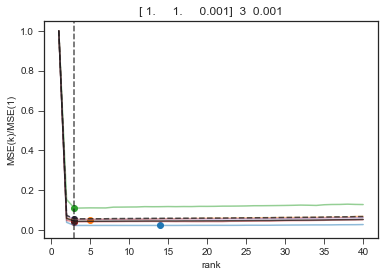

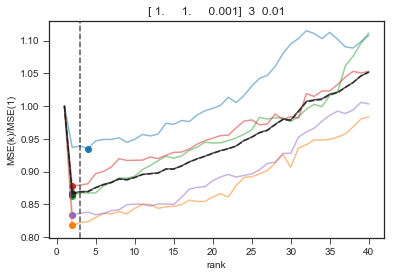

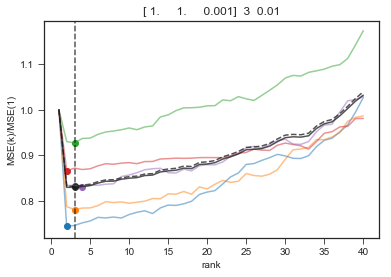

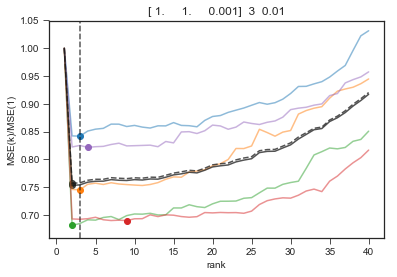

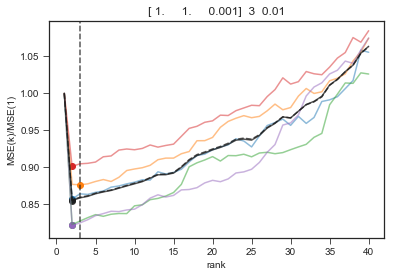

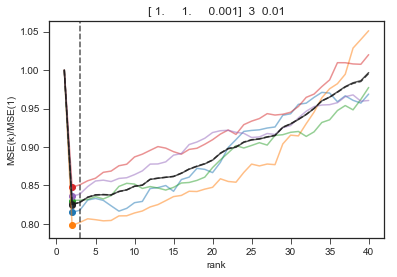

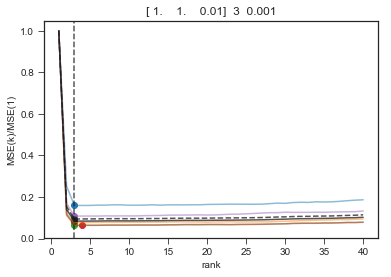

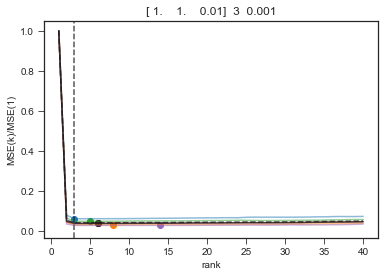

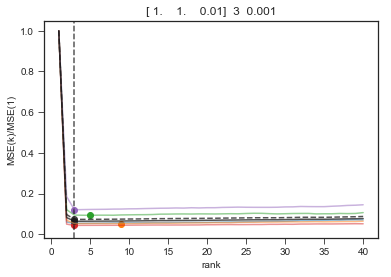

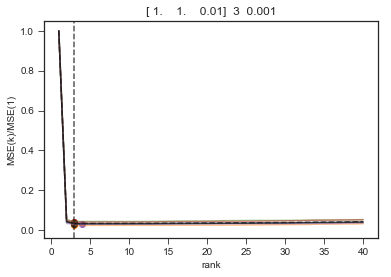

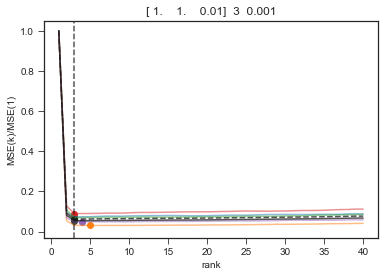

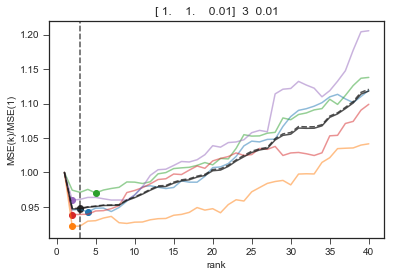

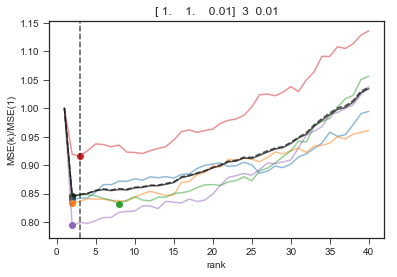

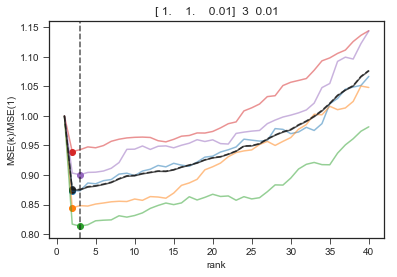

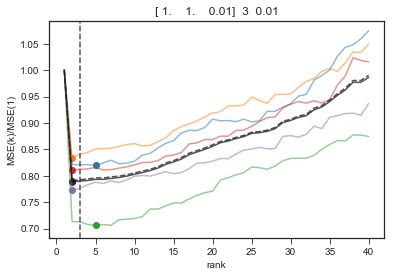

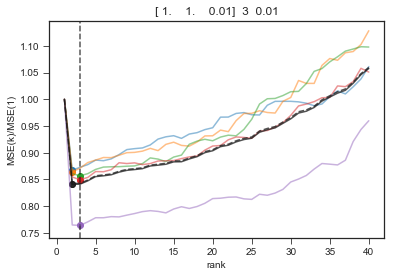

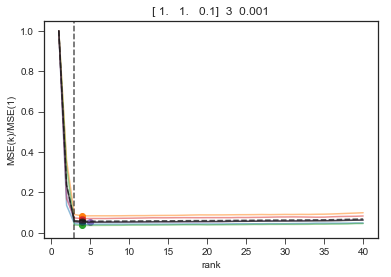

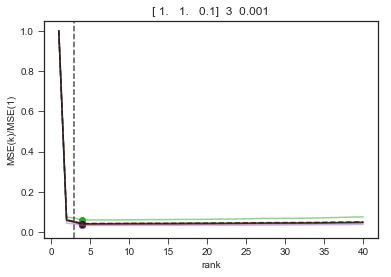

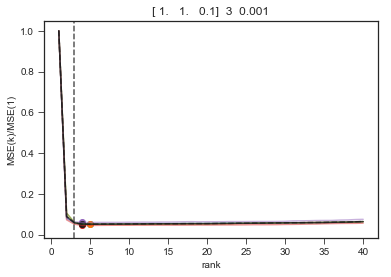

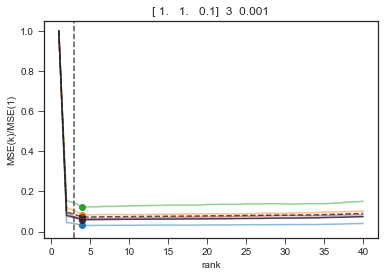

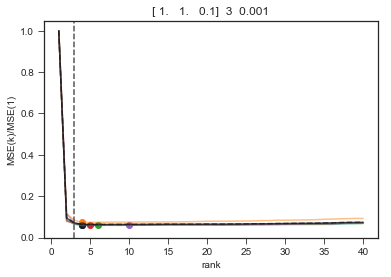

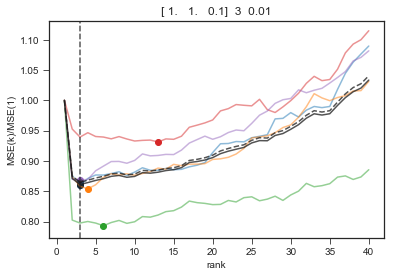

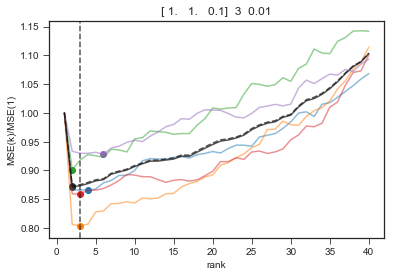

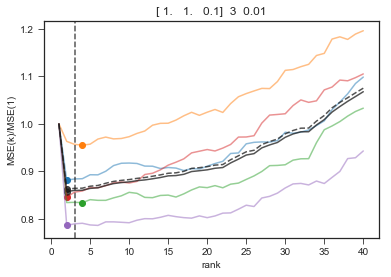

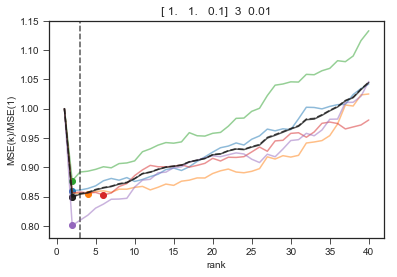

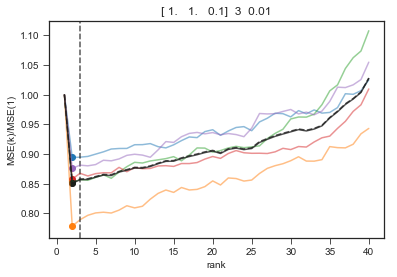

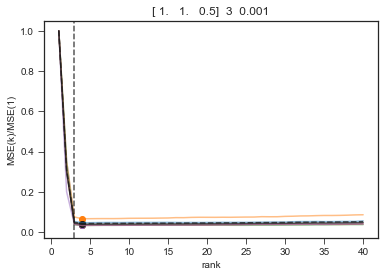

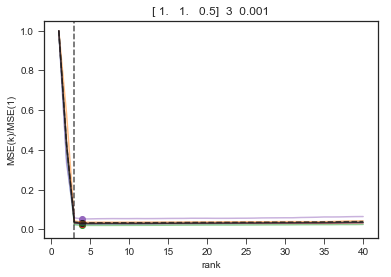

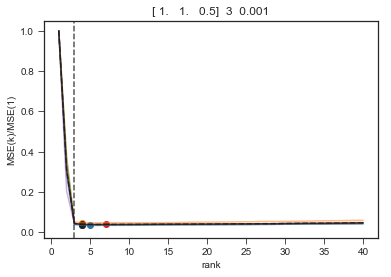

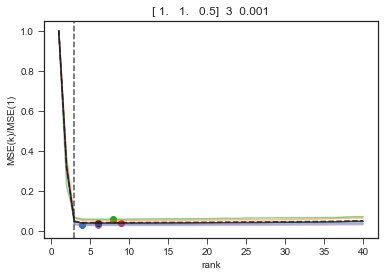

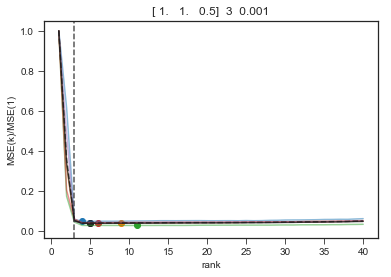

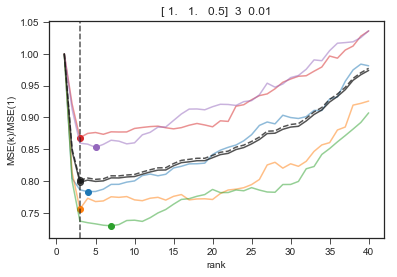

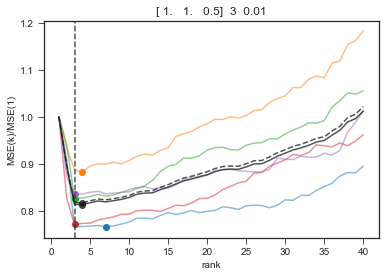

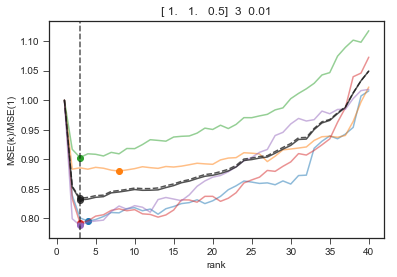

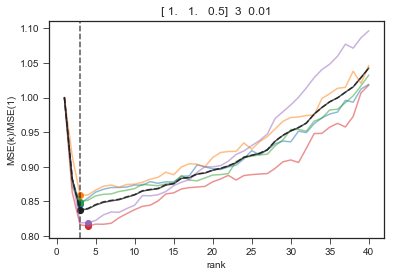

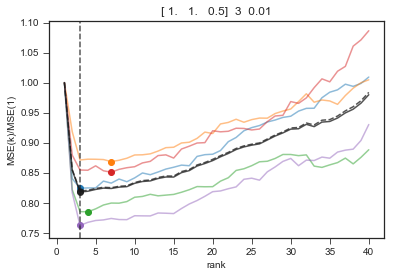

In [34]:
# reps = 5
# sim_id = 'd8e3f2a1e8f04d2e918c4c6052cf9337'
d_true = 3
n_folds = 5
err_list = [0.001,0.01]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_selection']['Sigma2'].values)
for sigma in sigmas:
#     plt.figure()
    sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_selection') & (these_sims['Sigma2']==sigma)]
    for err in err_list: 
        
        for sim_id in sigma_sims['simulation_identifier'].values:
            f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
            f = f[[col for col in f.columns if 'fitness' in col]]
            f = f.values
            this_set = f
            
            n_mutants = this_set.shape[0]
            n_conditions = this_set.shape[1]
            new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
            new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

            folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
            
            this_set = np.asarray([np.random.normal(this_set.flatten()[i],err) for i in range(len(this_set.flatten()))]).reshape(this_set.shape[0],this_set.shape[1])
            
            max_rank = int((n_folds-1)*n_conditions/n_folds)
            plt.figure()
            all_folds = np.zeros(max_rank)
            avg_folds = np.zeros(max_rank)
            for new_m,new_c in folds:
                old_m = sorted([i for i in range(n_mutants) if i not in new_m])
                old_c = sorted([i for i in range(n_conditions) if i not in new_c])
                rank_fit = []
                for rank in range(1,max_rank+1):
                    
                    both_old = this_set[np.repeat(old_m,len(old_c)),np.tile(old_c,len(old_m))].reshape(len(old_m),len(old_c))
#                     print(both_old.shape)
                    U2, s2, V2 = np.linalg.svd(both_old)
                    new_s = np.asarray(list(s2[:rank]) + list(np.zeros(s2[rank:].shape)))
                    #     new_s = np.asarray(list(s[:rank]) + list(np.zeros(len(conditions)-len(s[:rank]))))
                    S2 = np.zeros((U2.shape[0],V2.shape[0]))
                    S2[:min([U2.shape[0],V2.shape[0]]),:min([U2.shape[0],V2.shape[0]])] = np.diag(new_s)
                    
                    mut_new = this_set[np.repeat(new_m,len(old_c)),np.tile(old_c,len(new_m))].reshape(len(new_m),len(old_c))

#                     print(cond_new.shape)
#                     U1_m, s2_m, V2_m = np.linalg.svd(np.concatenate((np.dot(U2,np.dot(S2,V2)),mut_new)))
#                     new_s2_m = np.asarray(list(s2_m[:rank]) + list(np.zeros(s2_m[rank:].shape)))
#                     S2_m = np.zeros((U1_m.shape[0],V2_m.shape[0]))
#                     S2_m[:min([U1_m.shape[0],V2_m.shape[0]]),:min([U1_m.shape[0],V2_m.shape[0]])] = np.diag(new_s2_m)
                    
                    cond_new = this_set[np.repeat(old_m,len(new_c)),np.tile(new_c,len(old_m))].reshape(len(old_m),len(new_c))
#                     U2_c, s1_c, V1_c = np.linalg.svd(np.concatenate((np.dot(U2,np.dot(S2,V2)),cond_new),axis=1))
#                     new_s1_c = np.asarray(list(s1_c[:rank]) + list(np.zeros(s1_c[rank:].shape)))
#                     S1_c = np.zeros((U2_c.shape[0],V1_c.shape[0]))
#                     S1_c[:min([U2_c.shape[0],V1_c.shape[0]]),:min([U2_c.shape[0],V1_c.shape[0]])] = np.diag(new_s1_c)

                    D_hat = np.dot(U2[:,:rank],np.dot(S2,V2)[:rank,:])
#                     B_hat = np.dot(U1_m[:len(new_m),:rank],np.dot(S2,V2)[:rank,:len(new_c)]) # new mutants
#                     C_hat = np.dot(U2[:,:rank],np.dot(S1_c,V1_c)[:rank,:]) # new conditions
#                     A_hat = np.dot(U1_m[:len(new_m),:rank],np.dot(S1_c,V1_c)[:rank,:len(new_c)]) # both new
                    A_hat = np.dot(mut_new,np.dot(np.linalg.pinv(D_hat),cond_new))

                    both_new = this_set[np.repeat(new_m,len(new_c)),np.tile(new_c,len(new_m))].reshape(len(new_m),len(new_c))

#                     ll = loglikelihood_function(A_hat.flatten(),both_new.flatten(),np.asarray([err]*len(both_new.flatten())))
#                     rank_fit.append(ll)
                    rank_fit.append(np.mean((A_hat-both_new)**2))

                all_folds = all_folds + rank_fit
                avg_folds = avg_folds + rank_fit/rank_fit[0]
                plt.title(str(sigma)+'  '+str(d_true)+'  '+str(err))
#                 plt.title(str(d_true)+'  '+str(err))
                plt.plot(range(1,max_rank+1),(rank_fit/rank_fit[0]),alpha=0.5)
                plt.scatter(range(1,max_rank+1)[np.where(rank_fit==min(rank_fit))[0][0]],np.min((rank_fit/rank_fit[0])))
#                 plt.axvline(x=np.where)
                plt.axvline(x=d_true,color='k',linestyle='--',alpha=0.2)
            plt.plot(range(1,max_rank+1),(all_folds)/all_folds[0],'k',alpha=0.75)
            plt.scatter(range(1,max_rank+1)[np.where(all_folds==np.min(all_folds))[0][0]],np.min((all_folds/all_folds[0])),color='k',alpha=0.75)
            plt.plot(range(1,max_rank+1),(avg_folds)/avg_folds[0],'k--',alpha=0.75)
            plt.scatter(range(1,max_rank+1)[np.where(avg_folds==np.min(avg_folds))[0][0]],np.min((avg_folds/avg_folds[0])),color='k',alpha=0.75)
            plt.xlabel('rank')
            plt.ylabel('MSE(k)/MSE(1)')
#             plt.savefig('SVDAnalysis/BCV_selection_{}_{}.pdf'.format(sim_id,err),bbox_inches='tight')



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


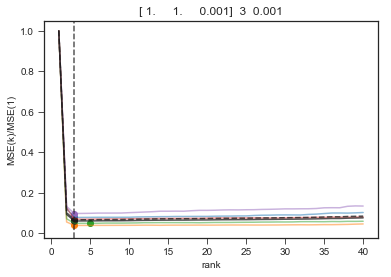

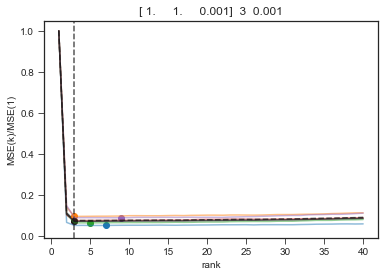

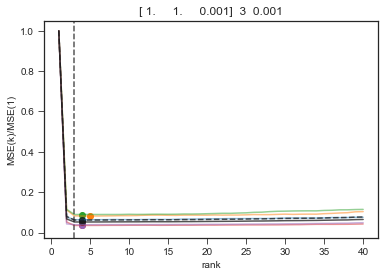

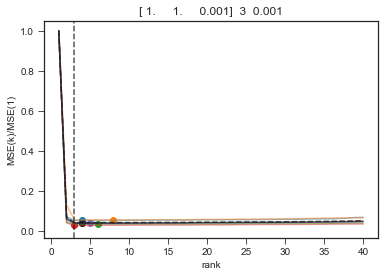

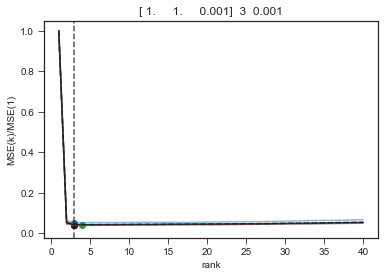

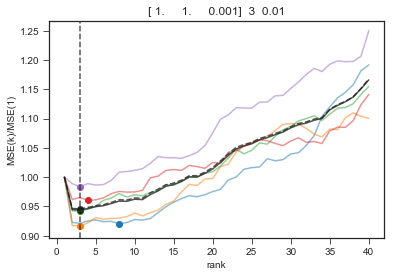

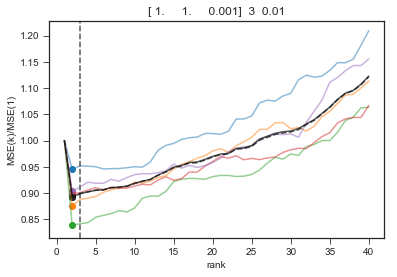

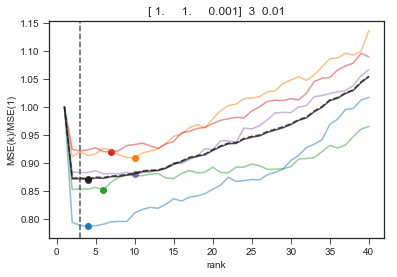

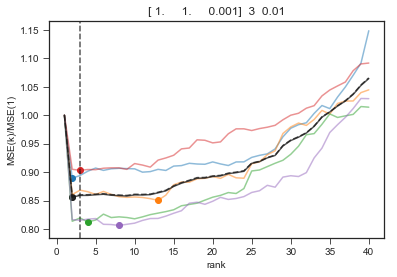

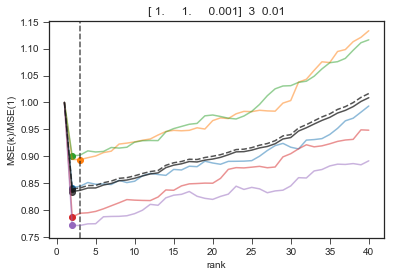

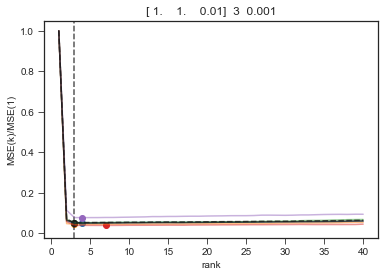

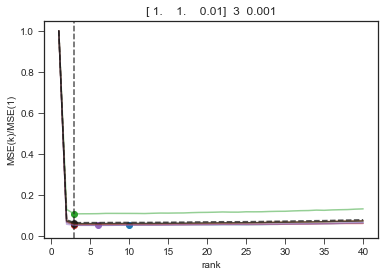

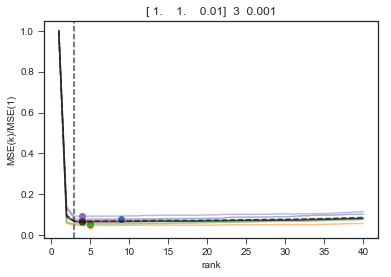

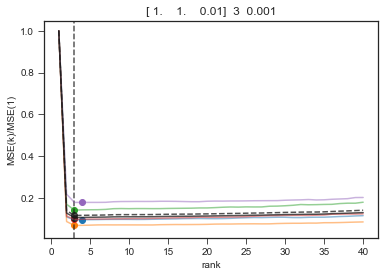

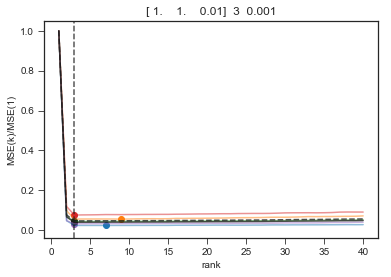

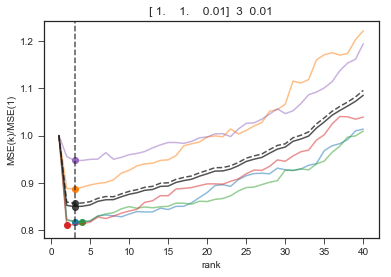

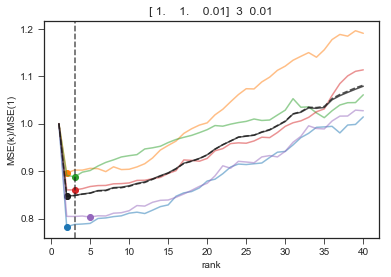

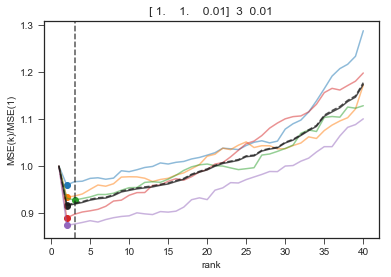

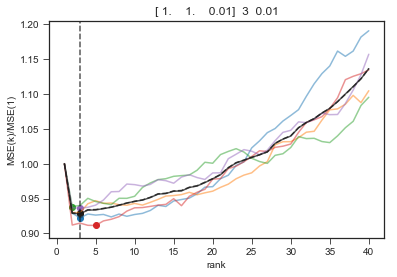

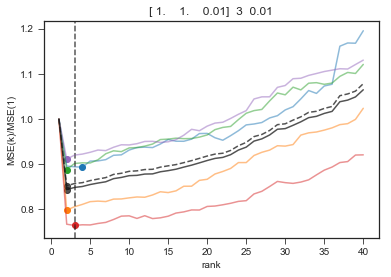

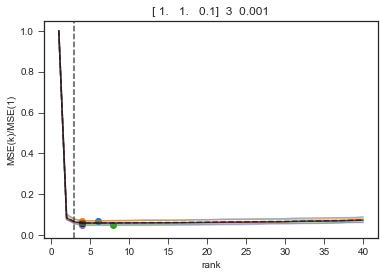

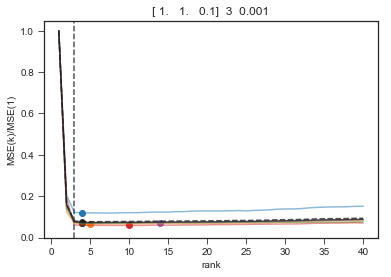

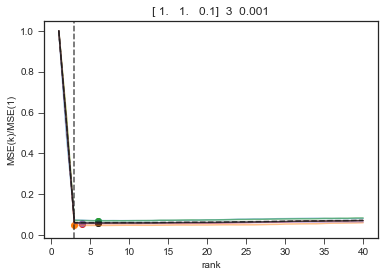

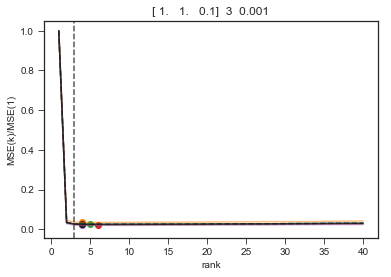

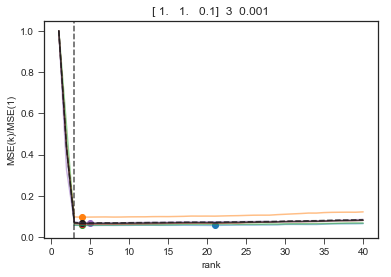

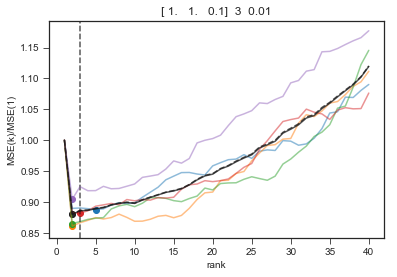

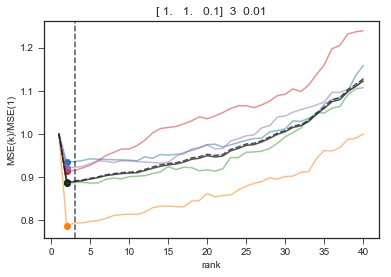

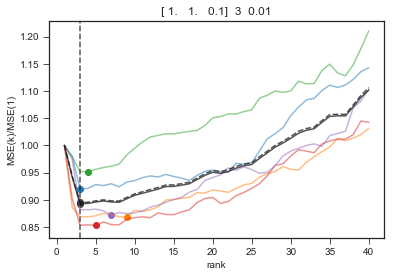

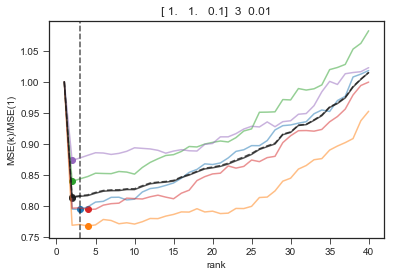

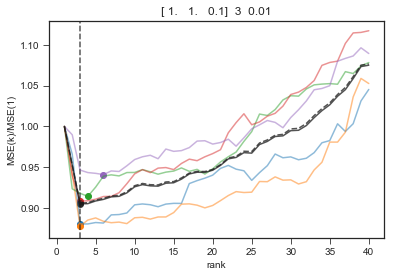

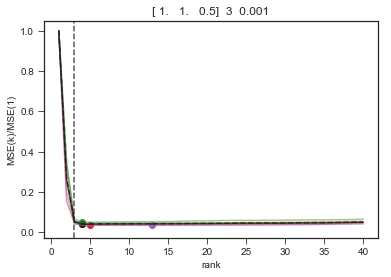

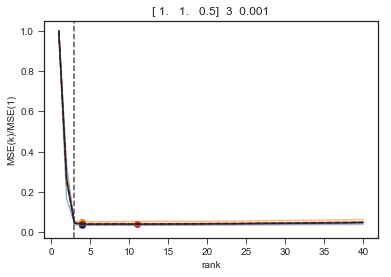

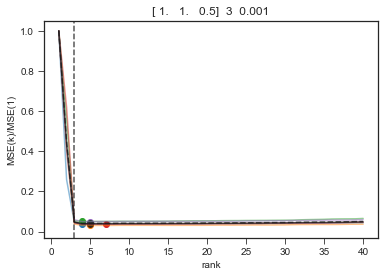

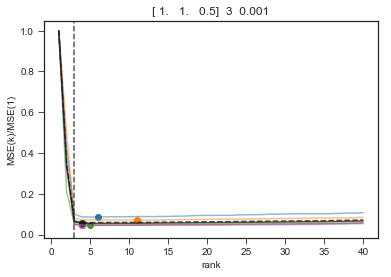

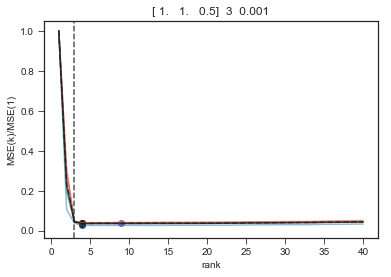

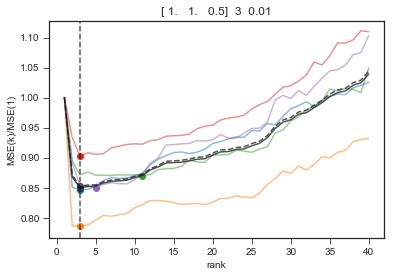

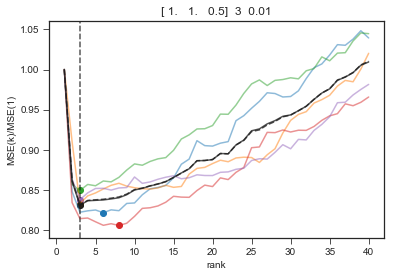

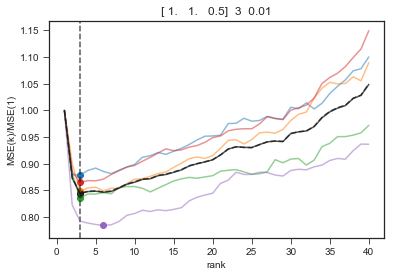

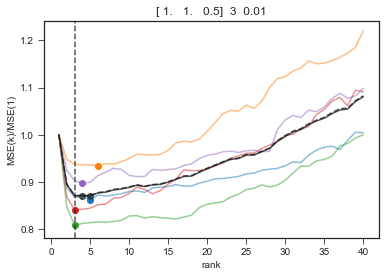

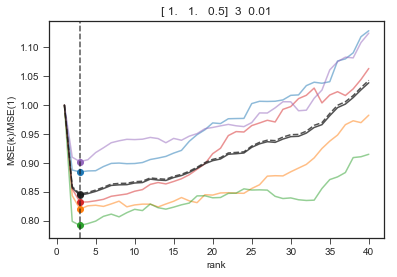

In [36]:
# reps = 5
# sim_id = 'd8e3f2a1e8f04d2e918c4c6052cf9337'
d_true = 3
n_folds = 5
err_list = [0.001,0.01]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_mutation']['weights'].values)
for sigma in sigmas:
#     plt.figure()
    sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_mutation') & (these_sims['weights']==sigma)]
    for err in err_list: 
        
        for sim_id in sigma_sims['simulation_identifier'].values:
            f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
            f = f[[col for col in f.columns if 'fitness' in col]]
            f = f.values
            this_set = f
            
            n_mutants = this_set.shape[0]
            n_conditions = this_set.shape[1]
            new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
            new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

            folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
            
            this_set = np.asarray([np.random.normal(this_set.flatten()[i],err) for i in range(len(this_set.flatten()))]).reshape(this_set.shape[0],this_set.shape[1])
            
#             U, s, V = np.linalg.svd(this_set)
            max_rank = int((n_folds-1)*n_conditions/n_folds)
            plt.figure()
            all_folds = np.zeros(max_rank)
            avg_folds = np.zeros(max_rank)
            for new_m,new_c in folds:
                old_m = sorted([i for i in range(n_mutants) if i not in new_m])
                old_c = sorted([i for i in range(n_conditions) if i not in new_c])
                rank_fit = []
                for rank in range(1,max_rank+1):
                    
                    both_old = this_set[np.repeat(old_m,len(old_c)),np.tile(old_c,len(old_m))].reshape(len(old_m),len(old_c))
#                     print(both_old.shape)
                    U2, s2, V2 = np.linalg.svd(both_old)
                    new_s = np.asarray(list(s2[:rank]) + list(np.zeros(s2[rank:].shape)))
                    #     new_s = np.asarray(list(s[:rank]) + list(np.zeros(len(conditions)-len(s[:rank]))))
                    S2 = np.zeros((U2.shape[0],V2.shape[0]))
                    S2[:min([U2.shape[0],V2.shape[0]]),:min([U2.shape[0],V2.shape[0]])] = np.diag(new_s)
                    
                    mut_new = this_set[np.repeat(new_m,len(old_c)),np.tile(old_c,len(new_m))].reshape(len(new_m),len(old_c))

#                     print(cond_new.shape)
#                     U1_m, s2_m, V2_m = np.linalg.svd(np.concatenate((np.dot(U2,np.dot(S2,V2)),mut_new)))
#                     new_s2_m = np.asarray(list(s2_m[:rank]) + list(np.zeros(s2_m[rank:].shape)))
#                     S2_m = np.zeros((U1_m.shape[0],V2_m.shape[0]))
#                     S2_m[:min([U1_m.shape[0],V2_m.shape[0]]),:min([U1_m.shape[0],V2_m.shape[0]])] = np.diag(new_s2_m)
                    
                    cond_new = this_set[np.repeat(old_m,len(new_c)),np.tile(new_c,len(old_m))].reshape(len(old_m),len(new_c))
#                     U2_c, s1_c, V1_c = np.linalg.svd(np.concatenate((np.dot(U2,np.dot(S2,V2)),cond_new),axis=1))
#                     new_s1_c = np.asarray(list(s1_c[:rank]) + list(np.zeros(s1_c[rank:].shape)))
#                     S1_c = np.zeros((U2_c.shape[0],V1_c.shape[0]))
#                     S1_c[:min([U2_c.shape[0],V1_c.shape[0]]),:min([U2_c.shape[0],V1_c.shape[0]])] = np.diag(new_s1_c)

                    D_hat = np.dot(U2[:,:rank],np.dot(S2,V2)[:rank,:])
#                     B_hat = np.dot(U1_m[:len(new_m),:rank],np.dot(S2,V2)[:rank,:len(new_c)]) # new mutants
#                     C_hat = np.dot(U2[:,:rank],np.dot(S1_c,V1_c)[:rank,:]) # new conditions
#                     A_hat = np.dot(U1_m[:len(new_m),:rank],np.dot(S1_c,V1_c)[:rank,:len(new_c)]) # both new
                    A_hat = np.dot(mut_new,np.dot(np.linalg.pinv(D_hat),cond_new))

                    both_new = this_set[np.repeat(new_m,len(new_c)),np.tile(new_c,len(new_m))].reshape(len(new_m),len(new_c))

#                     ll = loglikelihood_function(A_hat.flatten(),both_new.flatten(),np.asarray([err]*len(both_new.flatten())))
#                     rank_fit.append(ll)
                    rank_fit.append(np.mean((A_hat-both_new)**2))

                all_folds = all_folds + rank_fit
                avg_folds = avg_folds + rank_fit/rank_fit[0]
                plt.title(str(sigma)+'  '+str(d_true)+'  '+str(err))
#                 plt.title(str(d_true)+'  '+str(err))
                plt.plot(range(1,max_rank+1),(rank_fit/rank_fit[0]),alpha=0.5)
                plt.scatter(range(1,max_rank+1)[np.where(rank_fit==min(rank_fit))[0][0]],np.min((rank_fit/rank_fit[0])))
#                 plt.axvline(x=np.where)
                plt.axvline(x=d_true,color='k',linestyle='--',alpha=0.2)
            plt.plot(range(1,max_rank+1),(all_folds)/all_folds[0],'k',alpha=0.75)
            plt.scatter(range(1,max_rank+1)[np.where(all_folds==np.min(all_folds))[0][0]],np.min((all_folds/all_folds[0])),color='k',alpha=0.75)
            plt.plot(range(1,max_rank+1),(avg_folds)/avg_folds[0],'k--',alpha=0.75)
            plt.scatter(range(1,max_rank+1)[np.where(avg_folds==np.min(avg_folds))[0][0]],np.min((avg_folds/avg_folds[0])),color='k',alpha=0.75)
            plt.xlabel('rank')
            plt.ylabel('MSE(k)/MSE(1)')
#             plt.savefig('SVDAnalysis/BCV_mutation_{}_{}.pdf'.format(sim_id,err),bbox_inches='tight')




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


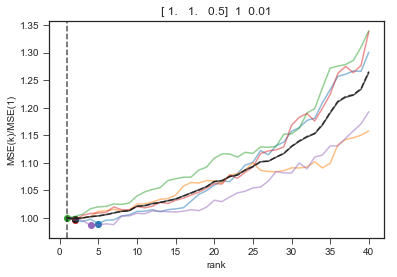

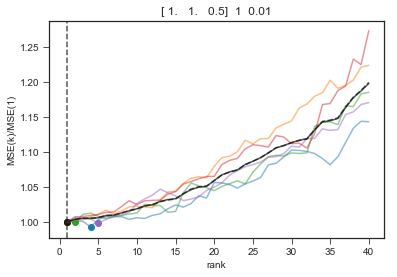

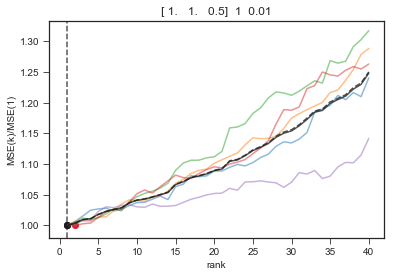

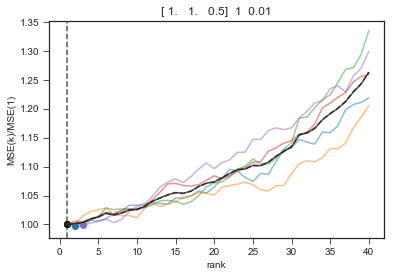

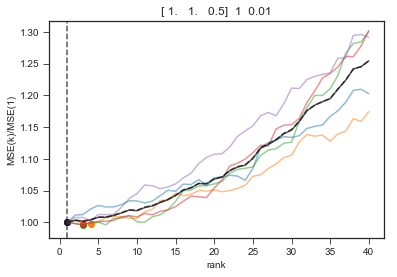

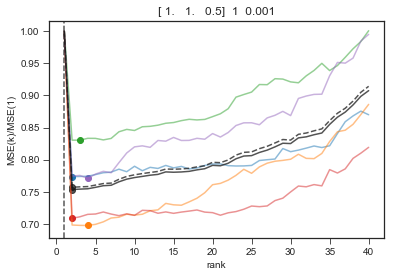

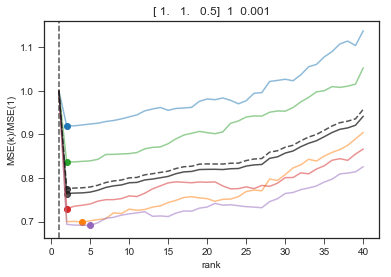

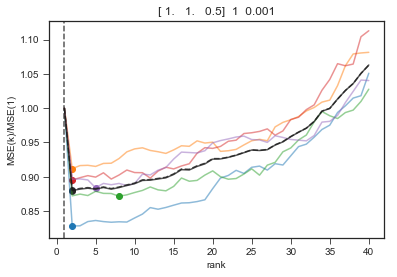

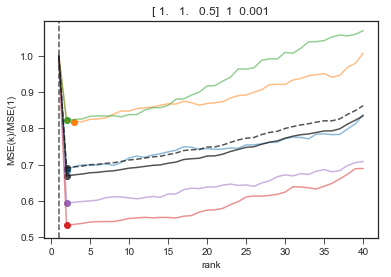

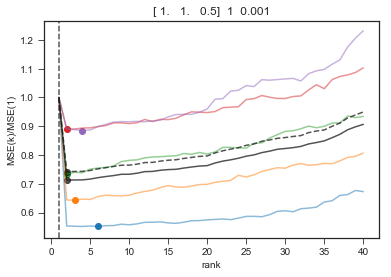

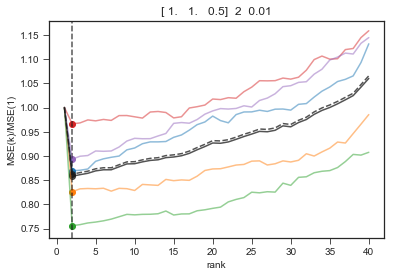

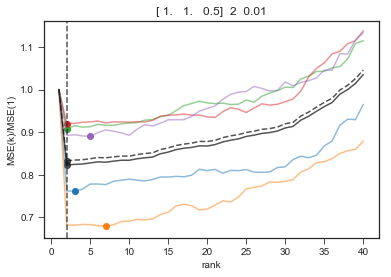

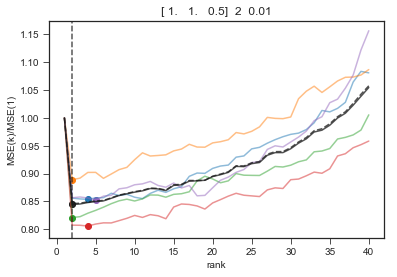

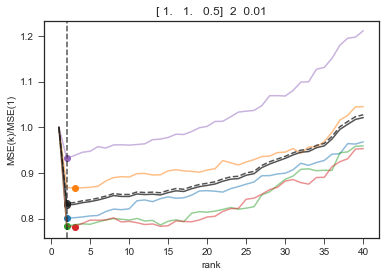

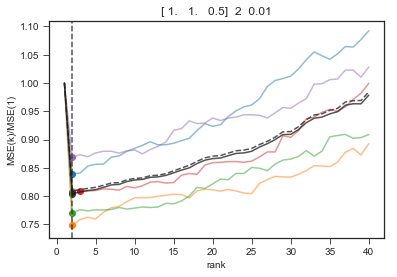

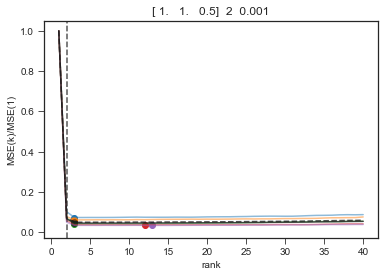

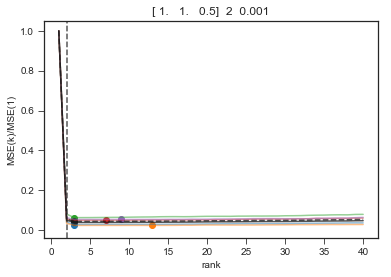

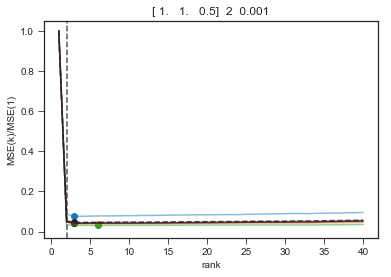

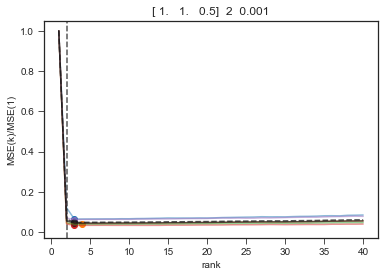

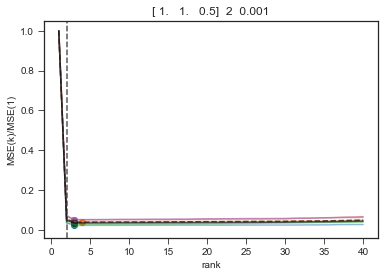

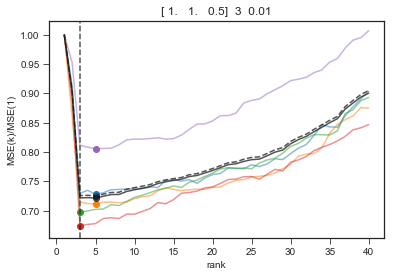

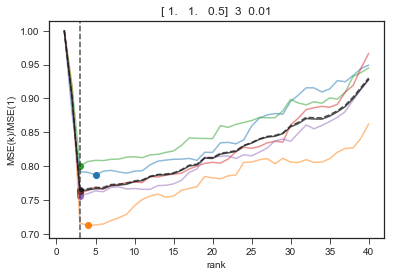

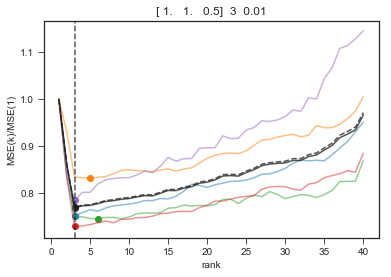

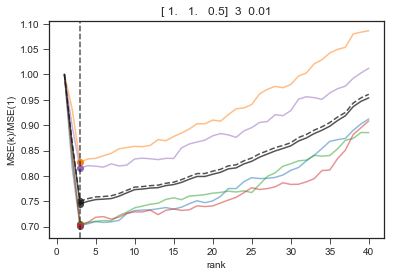

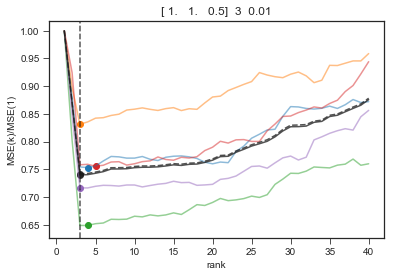

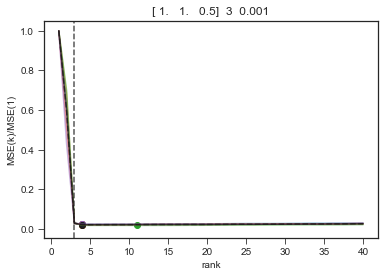

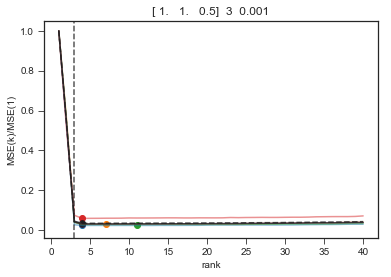

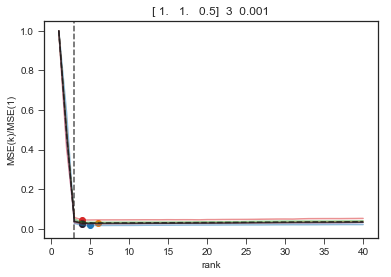

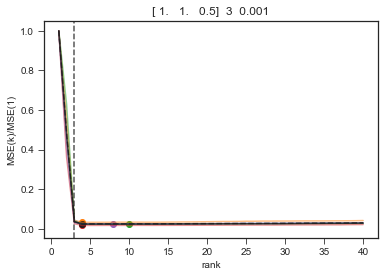

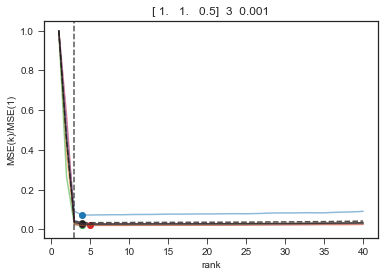

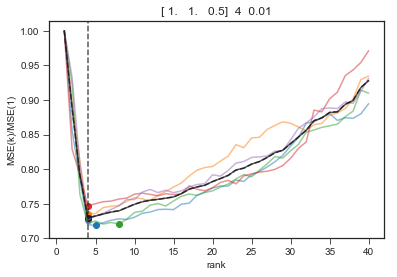

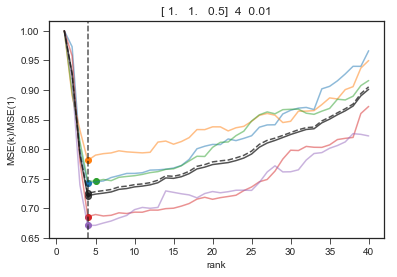

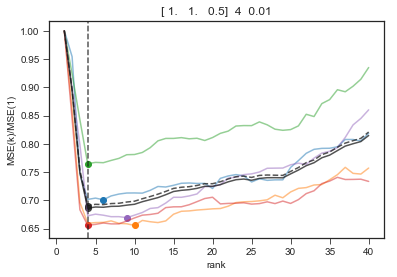

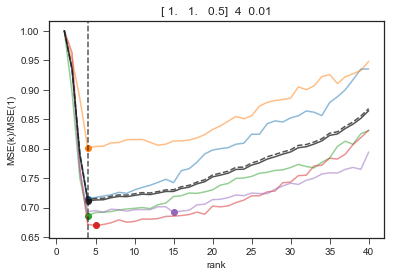

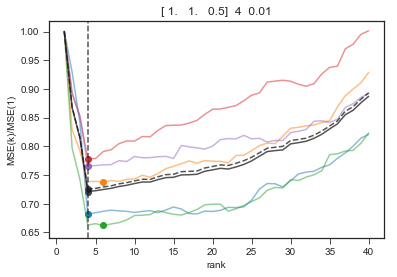

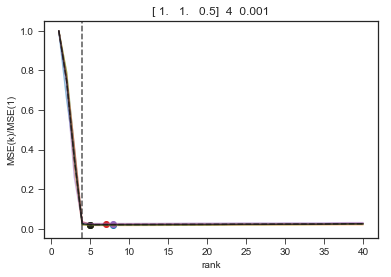

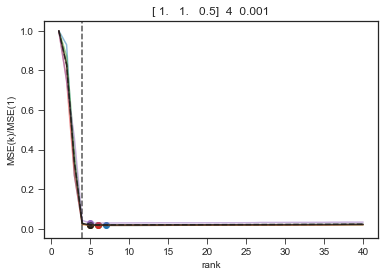

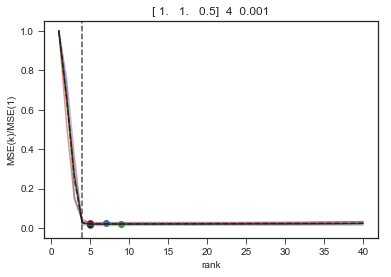

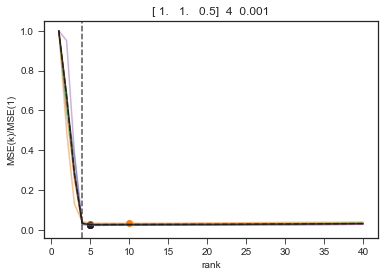

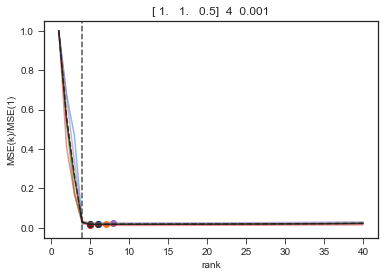

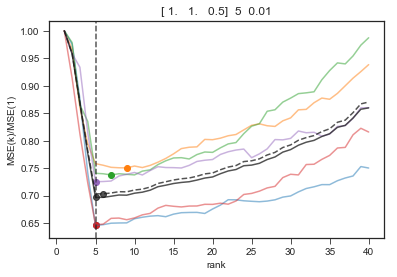

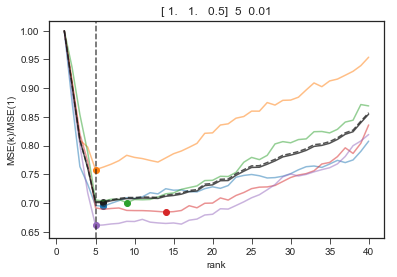

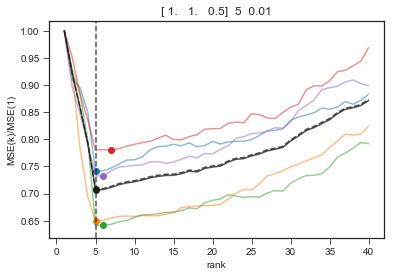

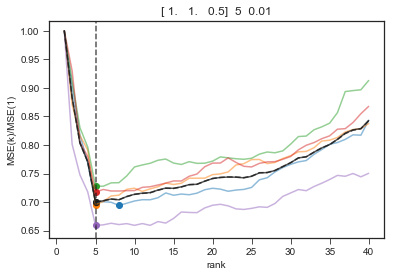

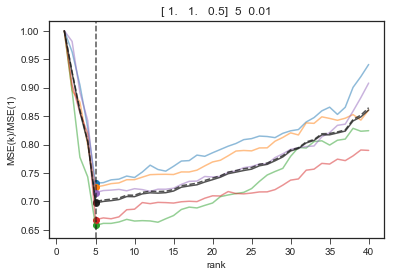

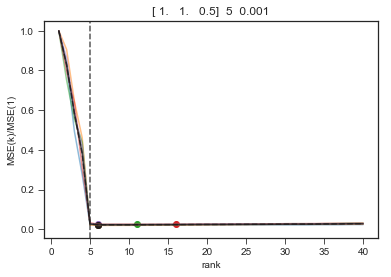

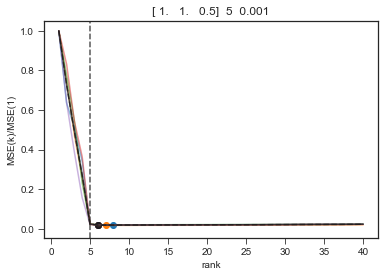

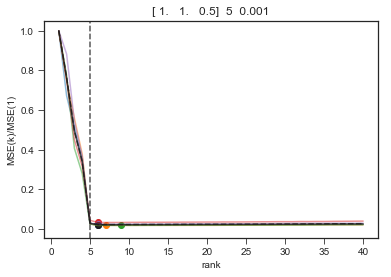

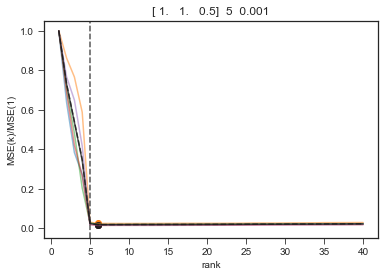

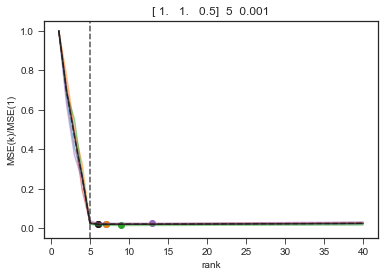

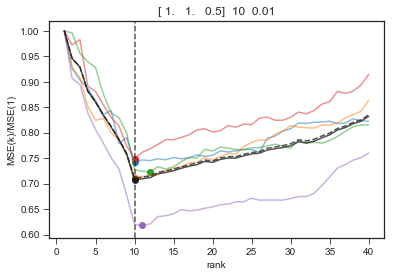

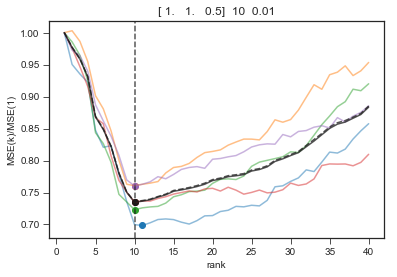

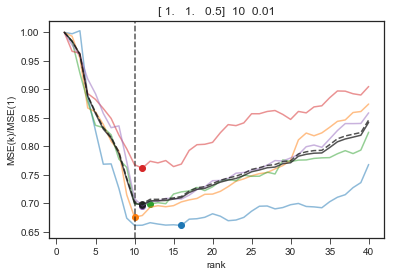

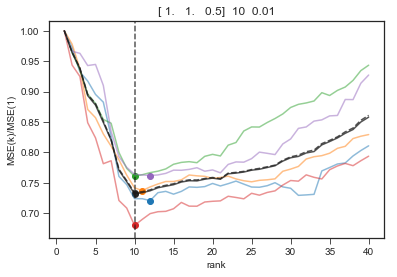

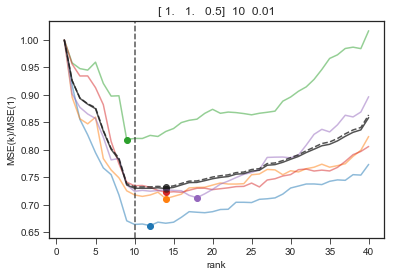

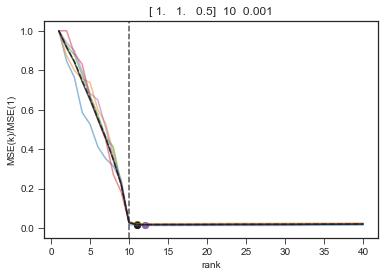

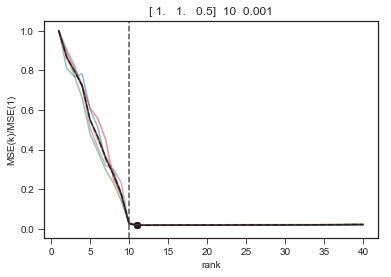

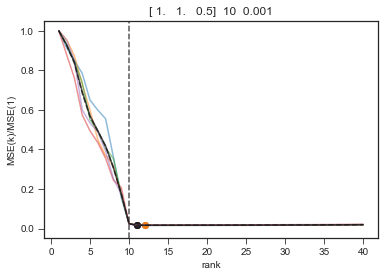

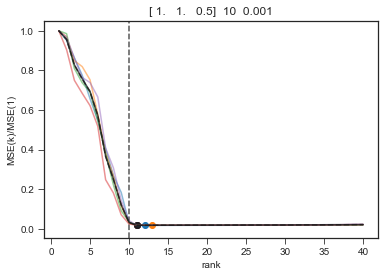

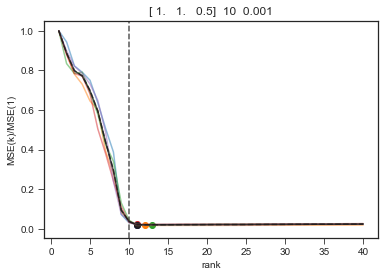

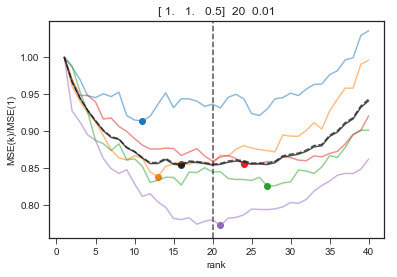

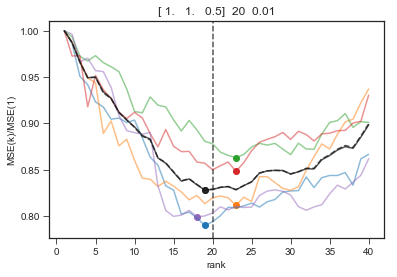

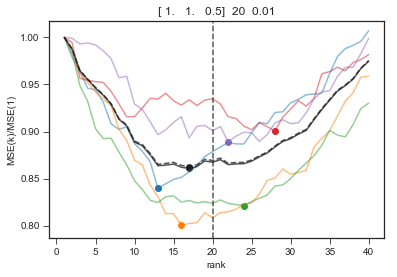

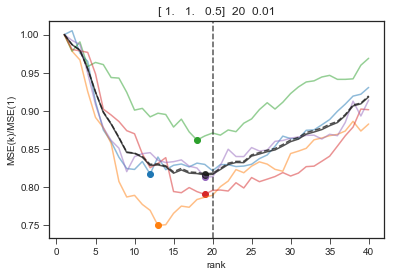

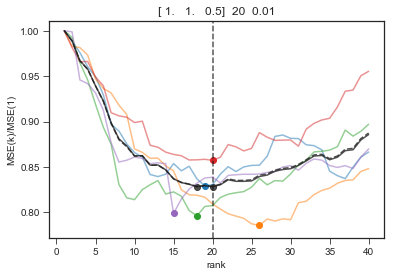

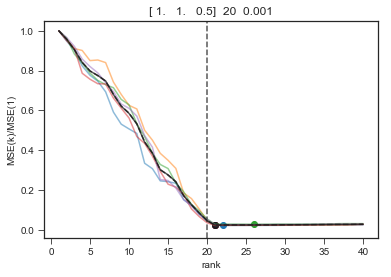

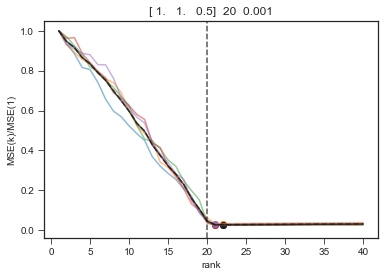

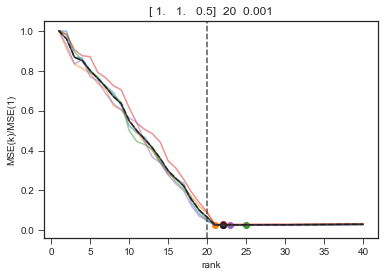

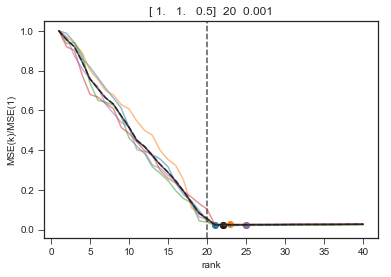

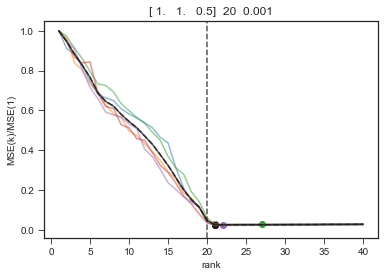

In [56]:
# reps = 5
# sim_id = 'd8e3f2a1e8f04d2e918c4c6052cf9337'
# d_true = 3



# for sim in these_sims
n_folds = 5
err_list = [1e-2,1e-3]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
for d_true in [1,2,3,4,5,10,20]:
#     plt.figure()
    sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['n_dimensions']==d_true)]
    for err in err_list: 
        plt.figure()
        for sim_id in [sigma_sims['simulation_identifier'].values[0]]:
            f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
            f = f[[col for col in f.columns if 'fitness' in col]]
            f = f.values
            this_set = f
            
            n_mutants = this_set.shape[0]
            n_conditions = this_set.shape[1]
            new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
            new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

            folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
            
            this_set = np.asarray([np.random.normal(this_set.flatten()[i],err) for i in range(len(this_set.flatten()))]).reshape(this_set.shape[0],this_set.shape[1])
            
#             U, s, V = np.linalg.svd(this_set)
            max_rank = int((n_folds-1)*n_conditions/n_folds)
            
            all_folds = np.zeros(max_rank)
            avg_folds = np.zeros(max_rank)
            for new_m,new_c in folds:
                old_m = sorted([i for i in range(n_mutants) if i not in new_m])
                old_c = sorted([i for i in range(n_conditions) if i not in new_c])
                rank_fit = []
                for rank in range(1,max_rank+1):
                    
                    both_old = this_set[np.repeat(old_m,len(old_c)),np.tile(old_c,len(old_m))].reshape(len(old_m),len(old_c))
#                     print(both_old.shape)
                    U2, s2, V2 = np.linalg.svd(both_old)
                    new_s = np.asarray(list(s2[:rank]) + list(np.zeros(s2[rank:].shape)))
                    #     new_s = np.asarray(list(s[:rank]) + list(np.zeros(len(conditions)-len(s[:rank]))))
                    S2 = np.zeros((U2.shape[0],V2.shape[0]))
                    S2[:min([U2.shape[0],V2.shape[0]]),:min([U2.shape[0],V2.shape[0]])] = np.diag(new_s)
                    
                    mut_new = this_set[np.repeat(new_m,len(old_c)),np.tile(old_c,len(new_m))].reshape(len(new_m),len(old_c))

#                     print(cond_new.shape)
#                     U1_m, s2_m, V2_m = np.linalg.svd(np.concatenate((np.dot(U2,np.dot(S2,V2)),mut_new)))
#                     new_s2_m = np.asarray(list(s2_m[:rank]) + list(np.zeros(s2_m[rank:].shape)))
#                     S2_m = np.zeros((U1_m.shape[0],V2_m.shape[0]))
#                     S2_m[:min([U1_m.shape[0],V2_m.shape[0]]),:min([U1_m.shape[0],V2_m.shape[0]])] = np.diag(new_s2_m)
                    
                    cond_new = this_set[np.repeat(old_m,len(new_c)),np.tile(new_c,len(old_m))].reshape(len(old_m),len(new_c))
#                     U2_c, s1_c, V1_c = np.linalg.svd(np.concatenate((np.dot(U2,np.dot(S2,V2)),cond_new),axis=1))
#                     new_s1_c = np.asarray(list(s1_c[:rank]) + list(np.zeros(s1_c[rank:].shape)))
#                     S1_c = np.zeros((U2_c.shape[0],V1_c.shape[0]))
#                     S1_c[:min([U2_c.shape[0],V1_c.shape[0]]),:min([U2_c.shape[0],V1_c.shape[0]])] = np.diag(new_s1_c)

                    D_hat = np.dot(U2[:,:rank],np.dot(S2,V2)[:rank,:])
#                     B_hat = np.dot(U1_m[:len(new_m),:rank],np.dot(S2,V2)[:rank,:len(new_c)]) # new mutants
#                     C_hat = np.dot(U2[:,:rank],np.dot(S1_c,V1_c)[:rank,:]) # new conditions
#                     A_hat = np.dot(U1_m[:len(new_m),:rank],np.dot(S1_c,V1_c)[:rank,:len(new_c)]) # both new
                    A_hat = np.dot(mut_new,np.dot(np.linalg.pinv(D_hat),cond_new))

                    both_new = this_set[np.repeat(new_m,len(new_c)),np.tile(new_c,len(new_m))].reshape(len(new_m),len(new_c))

#                     ll = loglikelihood_function(A_hat.flatten(),both_new.flatten(),np.asarray([err]*len(both_new.flatten())))
#                     rank_fit.append(ll)
                    rank_fit.append(np.mean((A_hat-both_new)**2))

                all_folds = all_folds + rank_fit
                avg_folds = avg_folds + rank_fit/rank_fit[0]
                plt.title(str(sigma)+'  '+str(d_true)+'  '+str(err))
#                 plt.title(str(d_true)+'  '+str(err))
                plt.plot(range(1,max_rank+1),(rank_fit/rank_fit[0]),alpha=0.5)
                plt.scatter(range(1,max_rank+1)[np.where(rank_fit==min(rank_fit))[0][0]],np.min((rank_fit/rank_fit[0])))
#                 plt.axvline(x=np.where)
                plt.axvline(x=d_true,color='k',linestyle='--',alpha=0.2)
            plt.plot(range(1,max_rank+1),(all_folds)/all_folds[0],'k',alpha=0.75)
            plt.scatter(range(1,max_rank+1)[np.where(all_folds==np.min(all_folds))[0][0]],np.min((all_folds/all_folds[0])),color='k',alpha=0.75)
            plt.plot(range(1,max_rank+1),(avg_folds)/avg_folds[0],'k--',alpha=0.75)
            plt.scatter(range(1,max_rank+1)[np.where(avg_folds==np.min(avg_folds))[0][0]],np.min((avg_folds/avg_folds[0])),color='k',alpha=0.75)
            plt.xlabel('rank')
            plt.ylabel('MSE(k)/MSE(1)')
#             plt.savefig('SVDAnalysis/BCV_weirduncle_{}_{}.pdf'.format(sim_id,err),bbox_inches='tight')



In [61]:
n_folds = 5
err_list = [1e-1,1e-2,1e-3]
svd_df = p.DataFrame(columns=['batch_name','sim_id','error','d_true','d_est','mse','r2','Sigma2','weights'])
for sim_id in these_sims['simulation_identifier'].values:
    
    for err in err_list:
        f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
        f = f[[col for col in f.columns if 'fitness' in col]]
        f = f.values
        this_set = f
    
        n_mutants = this_set.shape[0]
        n_conditions = this_set.shape[1]
        new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
        new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

        folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
  
        this_set = np.asarray([np.random.normal(this_set.flatten()[i],err) for i in range(len(this_set.flatten()))]).reshape(this_set.shape[0],this_set.shape[1])

        max_rank = int((n_folds-1)*n_conditions/n_folds)
        all_folds = np.zeros(max_rank)
        avg_folds = np.zeros(max_rank)
        for new_m,new_c in folds:
            old_m = sorted([i for i in range(n_mutants) if i not in new_m])
            old_c = sorted([i for i in range(n_conditions) if i not in new_c])
            rank_fit = []
            r2_fit = []
            for rank in range(1,max_rank+1):

                both_old = this_set[np.repeat(old_m,len(old_c)),np.tile(old_c,len(old_m))].reshape(len(old_m),len(old_c))

                U2, s2, V2 = np.linalg.svd(both_old)
                new_s = np.asarray(list(s2[:rank]) + list(np.zeros(s2[rank:].shape)))
                S2 = np.zeros((U2.shape[0],V2.shape[0]))
                S2[:min([U2.shape[0],V2.shape[0]]),:min([U2.shape[0],V2.shape[0]])] = np.diag(new_s)

                mut_new = this_set[np.repeat(new_m,len(old_c)),np.tile(old_c,len(new_m))].reshape(len(new_m),len(old_c))

                cond_new = this_set[np.repeat(old_m,len(new_c)),np.tile(new_c,len(old_m))].reshape(len(old_m),len(new_c))

                D_hat = np.dot(U2[:,:rank],np.dot(S2,V2)[:rank,:])
                A_hat = np.dot(mut_new,np.dot(np.linalg.pinv(D_hat),cond_new))

                both_new = this_set[np.repeat(new_m,len(new_c)),np.tile(new_c,len(new_m))].reshape(len(new_m),len(new_c))

                rank_fit.append(np.mean((A_hat-both_new)**2))
                r2_fit.append(pearsonr(A_hat.flatten(),both_new.flatten()))

            all_folds = all_folds + rank_fit
            avg_folds = avg_folds + rank_fit/rank_fit[0]
        d_est = range(1,max_rank+1)[np.where(all_folds==np.min(all_folds))[0][0]]
        mse = rank_fit[np.where(all_folds==np.min(all_folds))[0][0]]
        r2 = r2_fit[np.where(all_folds==np.min(all_folds))[0][0]]
        this_sim = these_sims[these_sims['simulation_identifier']==sim_id]
        this_dictionary = {'batch_name':this_sim['batch_name'].values[0],'sim_id':sim_id,'error':err,'d_true':this_sim['n_dimensions'].values[0],
                           'd_est':d_est,'mse':mse,'r2':r2[0],'Sigma2':this_sim['Sigma2'].values[0],'weights':this_sim['weights'].values[0]}
        
        svd_df = svd_df.append(this_dictionary,ignore_index=True)

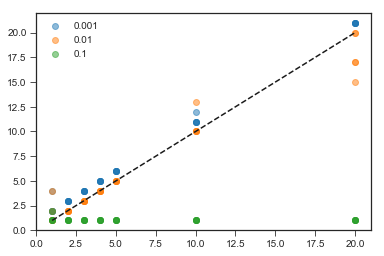

In [78]:
this_df = svd_df[svd_df['batch_name']=='fgm_simulation_set1_default']
plt.figure()
for err in np.unique(this_df['error'].values):
    this_err = this_df[this_df['error']==err]
#     for d_true in np.unique(this_err['d_true'].values):
#         this_d = this_err[this_err['d_true']==d_true]
#         plt.boxplot([d_true]*len(this_d['d_est'].values),this_d['d_est'].values)
    plt.scatter(this_err['d_true'].values,this_err['d_est'].values,alpha=0.5,label=err)
plt.plot([1,20],[1,20],'k--')
plt.xlim(0,21)
plt.ylim(0,22)
plt.legend()

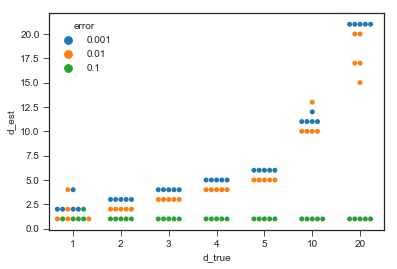

In [89]:
this_df = svd_df[svd_df['batch_name']=='fgm_simulation_set1_default']
plt.figure()
ax = sns.swarmplot(x='d_true',y='d_est',hue='error',data=this_df)
plt.savefig('SVDAnalysis/default_D_accuracy_summary.pdf',bbox_inches='tight')

In [100]:
### toy model

mutant_points = np.asarray([
    [1.0,0.0],
    [0.0,1.0],
    [0.5,0.25],
    [-.25,0.8],
    [-0.1,-0.5]
])
condition_points = np.asarray([
    [2.0,2.0],
    [3.0,-1.0],
    [-0.5,4.0],
])

F = calculate_fitness_linear(mutant_points,condition_points,0)

u,sig,v = np.linalg.svd(F)

In [106]:
np.dot(np.diag(sig),v)

array([[-2.56832556e+00,  1.71927820e+00, -5.62615597e+00],
       [-2.51071779e+00, -3.32401601e+00,  1.30361192e-01],
       [ 8.60000139e-17, -6.73043587e-17, -5.98260966e-17]])

(array([[-0.22728238, -0.00600903, -0.22596096, -0.6064072 , -0.72768026],
        [-0.18661183, -0.57972045,  0.0019753 , -0.57748237,  0.54370069],
        [-0.82761172,  0.45261153,  0.27767728, -0.01529873,  0.18128133],
        [-0.45049721, -0.39192792, -0.63891205,  0.48142746, -0.05885374],
        [ 0.16009326,  0.55265125, -0.68089974, -0.25841435,  0.37221541]]),
 array([0.15760166, 0.14788361, 0.13244951]),
 array([[-0.12242236,  0.94083091, -0.31599045],
        [-0.26400046, -0.33778464, -0.90344081],
        [ 0.95672176,  0.02717973, -0.28973219]]))

(-1.2, 1.2)

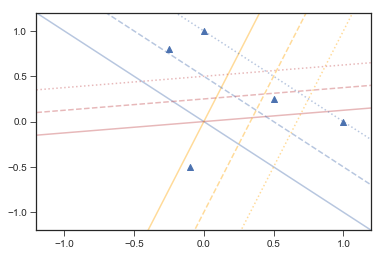

In [94]:
plt.scatter(x=mutant_points[:,0],y=mutant_points[:,1],marker='^',color='b')
xs = np.linspace(-1.2,1.2,100)
colorlist = ['b','orange','r']
patternlist = ['-','--',':']

for f in [0,1,2]:
    for c in range(3):
        plt.plot(xs,[f/condition_points[c,1]-condition_points[c,0]/condition_points[c,1]*x for x in xs],color=colorlist[c],linestyle=patternlist[f],alpha=0.4)
        
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)

In [115]:
err  = 0.1

u_w,sig_w,v_w = np.linalg.svd(F + np.random.normal(0,err,15).reshape(5,3))
u_n,sig_n,v_n = np.linalg.svd( np.random.normal(0,err,15).reshape(5,3))

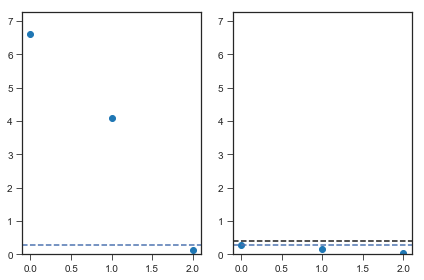

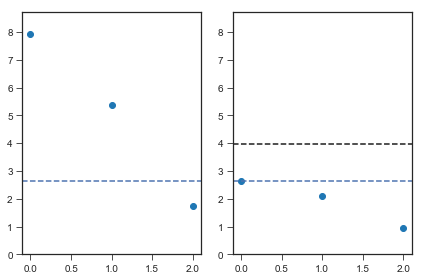

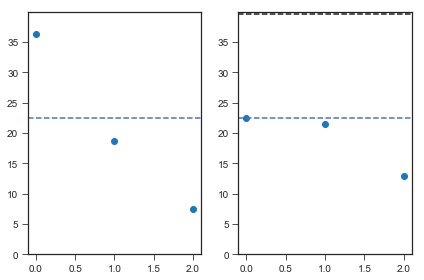

In [130]:
n_mutants = F.shape[0]
n_conditions = F.shape[1]

for err in [0.1,1.0,10.0]:

    u_w,sig_w,v_w = np.linalg.svd(F + np.random.normal(0,err,15).reshape(5,3))
    u_n,sig_n,v_n = np.linalg.svd( np.random.normal(0,err,15).reshape(5,3))
    
    height = max([sig_w[0],sig_n[0]])*1.1
    
    plt.figure()
    plt.subplot(121)
    plt.plot(range(3),sig_w,'o')
    plt.axhline(sig_n[0],color='b',linestyle='--')
    plt.ylim(0,height)
    plt.subplot(122)
    plt.plot(range(3),sig_n,'o')
    plt.axhline(sig_n[0],color='b',linestyle='--')
    plt.axhline(np.sqrt(2)*err*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions)),color='k',linestyle='--')
    plt.ylim(0,height)
    plt.tight_layout()

(-1.2, 1.2)

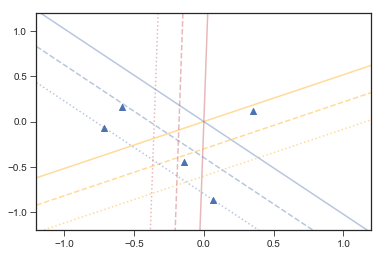

In [109]:
plt.scatter(x=u[:,0],y=u[:,1],marker='^',color='b')

v_new = np.dot(np.diag(sig),v).T

for f in [0,1,2]:
    for c in range(3):
        plt.plot(xs,[f/v_new[c,1]-v_new[c,0]/v_new[c,1]*x for x in xs],color=colorlist[c],linestyle=patternlist[f],alpha=0.4)


plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)

In [97]:
v

-39.291359491798126

In [99]:
sig

array([6.41917788e+00, 4.16770684e+00, 1.24519239e-16])